<a class='anchor' id='main'></a>

# Table of Contents

* [1. Web Scraper](#section1)
    * [1.1 NBA Player and ESPN Salary](#section_1_1)
    * [1.2 Inflation Rates](#section_1_2)
    * [1.3 Salary Cap](#section_1_3)
    * [1.4 Home Away Data](#section_1_4)
* [2. Player](#section2)
    * [2.1 Player Performance](#section_2_1)
    * [2.2 Player Salary Prediction](#section_2_2)
* [3. Team](#section3)
    * [3.1 Team Valuation on NBA Data](#section_3_1)
    * [3.2 Player Valuation on NBA Data](#section_3_2)
    * [3.3 Home Advantage Analysis](#section_3_3)


<a class='anchor' id='section1'></a>
<a class='anchor' id='section_1_1'></a>

## 1. Web Scraper

## 1.1 NBA and ESPN

### Import Library

---

In [55]:
from bs4 import BeautifulSoup
import urllib
import requests
import json
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import re
import time

### Get Data

---

#### Salary Data

In [58]:
# take year, return dataframe of player salary for that year
def player_salary(year):
    for page in range(1, 20):
        salary_url = f'http://www.espn.com/nba/salaries/_/year/{year}/page/{page}/seasontype/4'
        req = urllib.request.Request(salary_url , headers={'User-Agent': 'Mozilla/5.0'})
        content = urllib.request.urlopen(req).read()
        table = pd.read_html(content)[0]
        if page == 1:
            df = table.copy()
        else:
            df = pd.concat([df, table], axis = 0)
    
    # set df columns and drop index
    salary_cols = df.iloc[0,:].values
    df.columns = salary_cols
    df = df.loc[df['RK'] != 'RK']
    df.reset_index(drop = True, inplace = True)
    
    df['YEAR'] = year
    
    return df

In [59]:
# get salary data from 2000 to 2020
salary_df = player_salary('2000')
for year in range(2001, 2022):
    temp_df =  player_salary(str(year))
    salary_df = pd.concat([salary_df, temp_df], axis = 0)

salary_df.to_csv('player_salaries.csv', index=False)

In [ ]:
# preprocess salary data
salary_df.drop(['RK'], axis = 1, inplace = True)
salary_df['NAME'] = salary_df['NAME'].apply(lambda x: x.split(',')[0])
salary_df['SALARY'] = salary_df['SALARY'].replace('[\$,]', '', regex=True).astype(float)
salary_df.reset_index(inplace = True)
salary_df.to_csv('nba_salary_ESPN_cleaned.csv', index=False)

#### NBA Player Data

In [2]:
# take year, return dataframe of players stats for that year
def nba_player_data(year):
    # get player data from nba website in json format
    headers = {
        'User-Agent': 'Mozilla/5.0',
        'Referer': 'https://stats.nba.com/players/drives/',
        'x-nba-stats-origin': 'stats',
        'x-nba-stats-token': 'true',
    }
    player_url = f'https://stats.nba.com/stats/leaguedashplayerstats?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&GameSegment=&Height=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season={year}&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision=&Weight='
    req_url = requests.get(player_url, headers=headers)
    player_data = req_url.json()
    
    # get data by key: resultSets
    player_results = player_data['resultSets'][0]
    
    # get data feature names
    player_col_headers = player_results['headers']
    
    # get observations and set feature names
    player_results = json.dumps(player_results['rowSet'])
    df = pd.read_json(player_results)
    df.columns = player_col_headers
    df['year'] = year
    
    return df

In [ ]:
# get player data from 1996 to 2020
player_df = nba_player_data('1996-97')
for year in range(1997, 2020):
    temp_df =  nba_player_data(str(year) + '-' + str(year + 1)[-2:])
    player_df = pd.concat([player_df, temp_df], axis = 0)

# drop null values and reset index
player_df.dropna(axis = 0, inplace = True)
player_df.reset_index(inplace = True)
player_df.drop(['index'], axis = 1, inplace = True)
player_df.to_csv('nba_player_stats_official.csv', index=False)

#### Team Data

In [9]:
# take year, return dataframe of teams stats for that year
def nba_team_data(year):
    # get team data from nba website in json format
    headers = {
        'User-Agent': 'Mozilla/5.0',
        'Referer': 'https://stats.nba.com/players/drives/',
        'x-nba-stats-origin': 'stats',
        'x-nba-stats-token': 'true',
    }
    team_url = f'https://stats.nba.com/stats/leaguedashteamstats?Conference=&DateFrom=&DateTo=&Division=&GameScope=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season={year}&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision='
    req_url = requests.get(team_url, headers=headers)
    team_data = req_url.json()
    
    # get data by key: resultSets
    team_results = team_data['resultSets'][0]
    
    # get data feature names
    team_col_headers = team_results['headers']
    
    # get observations and set feature names
    team_results = json.dumps(team_results['rowSet'])
    df = pd.read_json(team_results)
    df.columns = team_col_headers
    df['year'] = year
    
    return df

In [10]:
# get team data from 1996 to 2020
team_df = nba_team_data('1996-97')
for year in range(1997, 2020):
    temp_df =  nba_team_data(str(year) + '-' + str(year + 1)[-2:])
    team_df = pd.concat([team_df, temp_df], axis = 0)

# drop null values and reset index
team_df.dropna(axis = 0, inplace = True)
team_df.reset_index(inplace = True)
team_df.drop(['index'], axis = 1, inplace = True)
team_df.to_csv('nba_team_stats_official.csv', index=False)

#### ESPN Player Data

In [2]:
teams_url = 'http://www.espn.com/nba/teams'
players_url = ''

In [3]:
html = urllib.request.urlopen(teams_url)
soup = BeautifulSoup(html, 'lxml')

In [4]:
links_store = str(soup.find_all('a'))

pattern = re.compile(r'href="/nba/team/_/name/\w*/\w*[-]?\w*')
matches = pattern.finditer(links_store)

teams = set()
for match in matches: 
    teams.add(match.group(0))

abbr_name = []
for link in teams:
    temp = link.split('/')
    abbr_name.append([temp[5], temp[6]])

In [3]:
roster_links = []
roster_link_format = 'https://www.espn.in/nba/team/roster/_/name/{abbr}'
for item in abbr_name:
    roster_links.append(roster_link_format.format(abbr=item[0]))

In [2]:
player_link_format = re.compile(r'https://www.espn.in/nba/player/_/id/\d*/\w*[-]?\w*')
player_list = set()
for roster_link in roster_links:
    roster_html = urllib.request.urlopen(roster_link)
    roster_soup = BeautifulSoup(roster_html, 'lxml')
    player_links = str(roster_soup.find_all('a'))
    players = player_link_format.finditer(player_links)
    for player in players:
        split_link = player.group(0).split('/')
        player_list.add((split_link[7], split_link[8]))
    time.sleep(2)
player_list = list(player_list)

In [1]:
master_df = pd.DataFrame(columns = ['PNAME','YEAR','GP','GS','MIN','FG','FG%','3PT','3P%','FT','FT%','OR','DR','REB','AST','BLK','STL','PF','TO','PTS'])

player_stat_link_format = 'https://www.espn.in/nba/player/stats/_/id/{idno}/{name}'
player_name_stat_links = []
for name_id_pair in player_list:
    player_link = player_stat_link_format.format(idno=name_id_pair[0], name=name_id_pair[1])
    player_name_stat_links.append([name_id_pair[1], player_link])

for player_item in player_name_stat_links:
    player_link, pname = player_item[1], player_item[0]
    player_stat_html = urllib.request.urlopen(player_link)
    player_stat_soup = BeautifulSoup(player_stat_html, 'lxml')
    
    try:
        # fetching the year-team from the year table
        year_table = player_stat_soup.find_all('table', {'class':'Table Table--align-right Table--fixed Table--fixed-left'})[0]
        year_vals = year_table.find_all('tr')
        year_vals = [year_val.getText() for year_val in year_vals][1:-1]
        year_vals = [year[:4] for year in year_vals]

        # fetching the average season stats
        regular_season_averages = player_stat_soup.find_all('table', {'class':'Table Table--align-right'})[0]
        table_headers = regular_season_averages.find_all('th')
        table_rows = regular_season_averages.find_all('tr')
        all_rows = []
        for row in table_rows[:-1]:
            vals = row.find_all('td')
            vals = [val.getText() for val in vals]
            all_rows.append(vals)

        all_rows.remove([])   
        for idx, row in enumerate(all_rows):
            all_rows[idx] = [pname] + [year_vals[idx]] + row

        for i in range(len(all_rows)):
            idx = len(master_df)
            master_df.loc[idx] = all_rows[i]
    
        time.sleep(2)
    except Exception as e:
        pass


master_df
master_df.to_csv('nba_player_stats.csv', index=False)

* [Go back to table of contents](#main)

---

---

<a class='anchor' id='section_1_2'></a>

## 1.2 Inflation Rates

In [11]:
from bs4 import BeautifulSoup
import urllib
import requests
import json
import pandas as pd
from matplotlib import pyplot as plt

In [12]:
def get_inflation_data():
    '''
    returns:
        dataframe of inflation data by year
    '''
    
    URL = 'https://www.usinflationcalculator.com/inflation/current-inflation-rates/#:~:text=The%20annual%20inflation%20rate%20for,at%208%3A30%20a.m.%20ET.'
    page = requests.get(URL)

    soup = BeautifulSoup(page.content, 'html.parser')
    
    header = soup.findAll('table')[0].findAll('tr')[0].text.split('\n')[1:-1]

    raw_rows = soup.findAll('table')[0].findAll('tr')[1:]

    inflation_table = [r.text.split('\n')[1:-1] for r in raw_rows]
    inflation_table = pd.DataFrame(inflation_table)
    inflation_table.columns = header

    # fix 2020 values
    numeric_cols = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Ave']
    inflation_table = inflation_table.replace('\xa0', 1)
    for c in numeric_cols+['Year']:
        inflation_table[c] = pd.to_numeric(inflation_table[c])

    # check which kind of mean
    # inflation_table['my_calc'] = inflation_table[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']].mean(axis=1)
    # uses arithmetic mean
    
    # add inflation factor with respect to 2019
    inf_vals = inflation_table['Ave'].values
    acc = 1
    inf_factors = list()
    for i in range(len(inf_vals)):
        inf_factors.append(acc)
        acc *= (1+inf_vals[i]/100)
    
    inflation_table['inf_factor'] = inf_factors
    
    inflation_table = inflation_table[['Year', 'Ave', 'inf_factor']]

    return inflation_table

inflation_factors = get_inflation_data()
inflation_factors.to_csv('inflation_rates.csv')

* [Go back to table of contents](#main)

---

---

<a class='anchor' id='section_1_3'></a>

## 1.3 Salary Cap

In [ ]:
from bs4 import BeautifulSoup
import urllib
import requests
import json
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
def get_salary_cap_data():
    '''
    function to get salary cap data
    
    returns:
        salary cap dataframe
    '''
    
    URL = 'https://basketball.realgm.com/nba/info/salary_cap'
    page = requests.get(URL)
    
    soup = BeautifulSoup(page.content, 'html.parser')
    
    # find table body information
    raw_rows = soup.findAll('table',class_='basketball compact')[0].find('tbody').findAll('tr')
    
    # table header
    columns = soup.findAll('table',class_='basketball compact')[0].find('thead').text.split('\n')
    
    # create table with data
    table = list()
    for r in raw_rows:
        table.append(r.text.split('\n'))
    
    df = pd.DataFrame(table, columns=columns)
    
    # extract starting season for YEAR variable
    df['YEAR'] = [int(str(y)[:4]) for y in df.Season.values]
    
    # convert salary string to number data type
    df['Salary Cap'] = [int(s.replace('$','').replace(",",'')) for s in df['Salary Cap'].values]
    
    # calculate the growth factor for each year compared to 2019
    reference = df[df.YEAR == 2019]['Salary Cap'].values[0]
    
    df['factor'] = reference/df['Salary Cap']
    
    df = df[['YEAR', 'Salary Cap', 'factor']]
    
    return df

salary_data = get_salary_cap_data()
salary_data.to_csv('salary_cap_data.csv')

* [Go back to table of contents](#main)

---

---

<a class='anchor' id='section_1_4'></a>

## 1.4 Home Away Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib
from bs4 import BeautifulSoup
import re
import time

In [2]:
teams_url = 'http://www.espn.com/nba/teams'
players_url = ''

In [3]:
html = urllib.request.urlopen(teams_url)
soup = BeautifulSoup(html, 'lxml')

In [4]:
links_store = str(soup.find_all('a'))

pattern = re.compile(r'href="/nba/team/_/name/\w*/\w*[-]?\w*')
matches = pattern.finditer(links_store)

teams = set()
for match in matches: 
    teams.add(match.group(0))

abbr_name = []
for link in teams:
    temp = link.split('/')
    abbr_name.append([temp[5], temp[6]])

In [65]:
# # scrape the data for home games
# game_type = 33
master_df = pd.DataFrame(columns=['PNAME', 'POS', 'TEAM',  'YEAR', 'TYPE', 'GP', 'GS', 'MIN', 'PTS', 'OR', 'DR', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'AST/TO', 'PER'])
year_list = range(2002, 2021)
for item in abbr_name:
    team_abbr = item[0]
    for year in year_list:
        season_no = year
        season_type = '2'
        game_types = ['33', '34']
        for game_type in game_types:
            time.sleep(3)
            test_split_link = 'https://www.espn.in/nba/team/stats/_/name/{team_abbr}/season/{season_no}/seasontype/{season_type}/split/{game_type}'.format(team_abbr=team_abbr, season_no=season_no, season_type=season_type, game_type=game_type)
            test_html = urllib.request.urlopen(test_split_link)
            test_soup = BeautifulSoup(test_html, 'lxml')
            players = []
            try:
                tables = test_soup.find_all('table')
                player_names = tables[0]
                rows = player_names.find_all('tr')
                # ignore first row
                for row in rows[1:]:
                    tds = row.find_all('td')[0]
                    spans = tds.find_all('span')[0]
                    try:
                        temp = [span.getText() for span in spans]
                        # remove trailing '*' after some of the position values
                        if len(temp) > 2:
                            temp = temp[:-1]
                        # removing leading spaces for position
                        temp[1] = temp[1].lstrip(' ')
                        players.append(temp)
                    except Exception as e:
                        pass

                all_rows = []
                tables = test_soup.find_all('table')
                player_stats = tables[1]
                rows = player_stats.find_all('tr')
                for row in rows[1:-1]:
                    tds = row.find_all('td')
                    vals = [td.getText() for td in tds]
                    all_rows.append(vals)

                concat_name_stats = []
                for idx in range(len(players)):
                    concat_name_stats.append(players[idx] + [team_abbr] + [season_no] + [game_type] +  all_rows[idx])

                temp_df = pd.DataFrame(concat_name_stats,columns=['PNAME', 'POS', 'TEAM',  'YEAR', 'TYPE', 'GP', 'GS', 'MIN', 'PTS', 'OR', 'DR', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'AST/TO', 'PER'])
                master_df = pd.concat([master_df, temp_df], axis=0)
            except Exception as e:
                pass

In [ ]:
master_df
master_df.to_csv('home_away.csv', index=False)

### Shots home away stats

In [15]:
teams_url = 'http://www.espn.com/nba/teams'
players_url = ''

In [16]:
html = urllib.request.urlopen(teams_url)
soup = BeautifulSoup(html, 'lxml')

In [17]:
links_store = str(soup.find_all('a'))

pattern = re.compile(r'href="/nba/team/_/name/\w*/\w*[-]?\w*')
matches = pattern.finditer(links_store)

teams = set()
for match in matches: 
    teams.add(match.group(0))

abbr_name = []
for link in teams:
    temp = link.split('/')
    abbr_name.append([temp[5], temp[6]])

[['atl', 'atlanta-hawks'],
 ['por', 'portland-trail'],
 ['mil', 'milwaukee-bucks'],
 ['tor', 'toronto-raptors'],
 ['okc', 'oklahoma-city'],
 ['hou', 'houston-rockets'],
 ['ind', 'indiana-pacers'],
 ['sa', 'san-antonio'],
 ['sac', 'sacramento-kings'],
 ['gs', 'golden-state'],
 ['bkn', 'brooklyn-nets'],
 ['chi', 'chicago-bulls'],
 ['den', 'denver-nuggets'],
 ['wsh', 'washington-wizards'],
 ['mem', 'memphis-grizzlies'],
 ['cle', 'cleveland-cavaliers'],
 ['mia', 'miami-heat'],
 ['orl', 'orlando-magic'],
 ['phi', 'philadelphia-76ers'],
 ['det', 'detroit-pistons'],
 ['dal', 'dallas-mavericks'],
 ['bos', 'boston-celtics'],
 ['lal', 'los-angeles'],
 ['utah', 'utah-jazz'],
 ['phx', 'phoenix-suns'],
 ['lac', 'la-clippers'],
 ['no', 'new-orleans'],
 ['min', 'minnesota-timberwolves'],
 ['cha', 'charlotte-hornets'],
 ['ny', 'new-york']]

In [18]:
home_split_format = 'https://www.espn.in/nba/team/stats/_/name/{team_abbr}/season/{season_no}/seasontype/{season_type}/split/{game_type}'
# codes for season type [2:Regular Season, 3:Post Season]
# codes for game_type [33: Home, 34:Away]
# data is available from 2002 - 2020

In [1]:
# # scrape the data for home games
# game_type = 33
shot_df = pd.DataFrame(columns=['PNAME', 'POS', 'TEAM',  'YEAR', 'TYPE', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', '2PM', '2PA', '2P%', 'SC-EFF', 'SH-EFF'])
year_list = range(2002, 2021)
for item in abbr_name:
    team_abbr = item[0]
    for year in year_list:
        season_no = year
        season_type = '2'
        game_types = ['33', '34']
        for game_type in game_types:
            time.sleep(3)
            test_split_link = 'https://www.espn.in/nba/team/stats/_/name/{team_abbr}/season/{season_no}/seasontype/{season_type}/split/{game_type}'.format(team_abbr=team_abbr, season_no=season_no, season_type=season_type, game_type=game_type)
            test_html = urllib.request.urlopen(test_split_link)
            test_soup = BeautifulSoup(test_html, 'lxml')
            players = []
            try:
                tables = test_soup.find_all('table')
                player_names = tables[2]
                rows = player_names.find_all('tr')
                # ignore first row
                for row in rows[1:]:
                    tds = row.find_all('td')[0]
                    spans = tds.find_all('span')[0]
                    try:
                        temp = [span.getText() for span in spans]
                        # remove trailing '*' after some of the position values
                        if len(temp) > 2:
                            temp = temp[:-1]
                        # removing leading spaces for position
                        temp[1] = temp[1].lstrip(' ')
                        players.append(temp)
                    except Exception as e:
                        pass

                all_rows = []
                tables = test_soup.find_all('table')
                player_stats = tables[3]
                rows = player_stats.find_all('tr')
                for row in rows[1:-1]:
                    tds = row.find_all('td')
                    vals = [td.getText() for td in tds]
                    all_rows.append(vals)

                concat_shot_stats = []
                for idx in range(len(players)):
                    try:
                        concat_shot_stats.append(players[idx] + [team_abbr] + [season_no] + [game_type] +  all_rows[idx])
                    except Exception as e:
                        pass
                temp_df = pd.DataFrame(concat_shot_stats,columns=['PNAME', 'POS', 'TEAM',  'YEAR', 'TYPE', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', '2PM', '2PA', '2P%', 'SC-EFF', 'SH-EFF'])
                shot_df = pd.concat([shot_df, temp_df], axis=0)
            except Exception as e:
                pass


In [53]:
shot_df.to_csv('shots_home_away_stats.csv', index=False)

* [Go back to table of contents](#main)

---

---

<a class='anchor' id='section2'></a>
<a class='anchor' id='section_2_1'></a>

## 2. Player

## 2.1 Player Performance

In [1]:
#Library Import
import pandas as pd
import numpy as np
import seaborn as sns 
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot as plt

import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression,Lasso,Ridge
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA 
pd.set_option('display.max_rows', 500)

from bs4 import BeautifulSoup 
import requests
import json
import re
import urllib
from time import sleep

### Web Scraping

In [2]:
# Team URL Extraction
def build_team_urls():
    # Open the espn teams webpage and extract the names of each roster available.
    f = urllib.request.urlopen('http://www.espn.com/nba/teams')
    teams_source = f.read().decode('utf-8')
    teams = dict(re.findall("www\.espn\.com/nba/team/_/name/(\w+)/(.+?)\",", teams_source))
    # Using the names of the rosters, create the urls of each roster
    roster_urls = []
    for key in teams.keys():
        # each roster webpage follows this general pattern.
        roster_urls.append('http://www.espn.com/nba/team/roster/_/name/' + key + '/' + teams[key])
        teams[key] = str(teams[key])
    return dict(zip(teams.values(), roster_urls))
#Extract Players basic information
def player_info(team_url):
    f = urllib.request.urlopen(team_url)
    teams_source = f.read().decode('utf-8')
    sleep(0.5)
    player_regex = ('"athletes":(.+?)"subType":')
    player = re.findall(player_regex, teams_source)[0]
    # Convert palyers to pandas dataframe
    return pd.read_json(player[1:-4], lines=True)
#Convert height
def convert_height(h):
    split_height = h.split(' ')
    feet = float(split_height[0].replace("\'",""))
    inches = float(split_height[1].replace("\"",""))
    return (feet*12 + inches)

In [3]:
# Get Team URLs and scrape the data
team_urls = build_team_urls()
player_physical= []
for url in team_urls.values():
    player_physical.append(player_info(url))
player_physical = pd.concat(player_physical).dropna().reset_index(drop=True)

/Users/yangzibin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [4]:
# Convert the format in the dataset
player_physical['height'] = [convert_height(x) for x in player_physical['height']]
player_physical['weight'] = [float(x.split(" ")[0]) for x in player_physical['weight']]
player_physical['salary'] = [int(re.sub(r'[^\d.]+', '', s)) if isinstance(s, str) else s for s in player_physical['salary'].values]

### Data Cleaning

In [5]:
# Data Import from official website
player_stats = pd.read_csv('nba_player_stats_official.csv')

In [6]:
player_att = player_physical[['name','position','height','weight']]

In [7]:
# Merge with NBA official data over the years 
df = pd.merge(player_att,player_stats,how = 'left', left_on=['name'], right_on = ['PLAYER_NAME']).drop(columns = ['PLAYER_NAME']).dropna()

### EDA -  Physical Attribute and Performance

### ESPN Players Physical Attribute - Height, Weight, Age

In [10]:
# Individual Physical Attributes
physical_att = player_physical[['name','position','age','height','weight','GP','GS', 'MIN', 'FGM',
       'FGA', 'FG%', '3PTM', '3PTA', '3P%', 'FTM', 'FTA', 'FT%', 'OR', 'DR',
       'REB', 'AST', 'BLK', 'STL', 'PF', 'TO', 'PTS']].dropna()

KeyError: "['3P%', 'FT%', 'GS', 'TO', '3PTM', 'DR', 'OR', 'age', 'FG%', '3PTA'] not in index"

In [ ]:
physical_att['age'].describe()

In [ ]:
sns.distplot(physical_att['age'])
plt.title('Age Distribution')
plt.axvline(x=26.31,color='r')

In [ ]:
sns.distplot(physical_att['height'])
plt.title('Height Distribution')
plt.xlabel('height (inch)')
plt.axvline(x=78.45,color='r')

In [ ]:
physical_att.height.describe()

In [ ]:
sns.distplot(physical_att['weight'])
plt.title('Weight Distribution')
plt.xlabel('Weight (lbs)')
plt.axvline(x=217.7,color='r')

In [ ]:
physical_att.weight.describe()

### Feature of Importance - Height and Weight

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6)) 
mask = np.zeros_like(physical_att.corr()[['weight','height']])
mask[np.triu_indices_from(mask)] = 1
sns.heatmap(physical_att.corr()[['weight','height']], mask= mask, ax= ax, annot= True,cmap="YlGnBu")

### Model Fitting - Linear Regression

In [ ]:
# Preparing X and y values for model fitting
X = physical_att[['height','weight']]
y = physical_att[['GP','GS', 'MIN', 'FGM',
       'FGA', 'FG%', '3PTM', '3PTA', '3P%', 'FTM', 'FTA', 'FT%', 'OR', 'DR',
       'REB', 'AST', 'BLK', 'STL', 'PF', 'TO', 'PTS']]
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
    test_size = 0.25, random_state = 2)

In [ ]:
# Normalize the data
# mean value of the training set height and weight
m = X_train.mean()
y_m = y_train.mean()
# standard deviation of height and weight
s = X_train.std()
y_s = y_train.std()
# Normalize the training set and test set
X_train = (X_train - m) / s
X_test = (X_test - m) / s
y_train = (y_train - y_m) / y_s
y_test = (y_test - y_m) / y_s

In [ ]:
# Fit linear regression models using each performance score as target variable and
#  height and weight as input variables.  
mse_test = []
mse_train =[]
perf = ['GP','GS', 'MIN', 'FGM',
       'FGA', 'FG%', '3PTM', '3PTA', '3P%', 'FTM', 'FTA', 'FT%', 'OR', 'DR',
       'REB', 'AST', 'BLK', 'STL', 'PF', 'TO', 'PTS']
for target in perf:
    X_const = sm.add_constant(X_train)
    model = sm.OLS(y_train[target], X_train)
    res = model.fit()
    #print('\nResult Summary {0}:'.format(target))
    #_ = print(res.summary2())
    #Evaluation in the test set
    pred = res.predict(X_test)
    # Records the Test error
    mse_test.append(mean_squared_error(y_test[target], pred))
    pred = res.predict(X_train)
    # Records the Test error
    mse_train.append(mean_squared_error(y_train[target], pred))

In [ ]:
# Combine Performance of each model on training set and test set
pd.DataFrame({'target':perf,'score':mse_test,'train_score':mse_train})

### Model Detail - REB, BLK,OR
Rebounds which consist of offensive rebounds and defensive rebound, blocks have the best performance.

In [ ]:
# Model Details
X_const = sm.add_constant(X_train)
model = sm.OLS(y_train['REB'], X_train)
res = model.fit()
print('\nResult Summary {0}:'.format(target))
_ = print(res.summary2())

In [ ]:
X_const = sm.add_constant(X_train)
model = sm.OLS(y_train['BLK'], X_train)
res = model.fit()
print('\nResult Summary {0}:'.format(target))
_ = print(res.summary2())

In [ ]:
X_const = sm.add_constant(X_train)
model = sm.OLS(y_train['OR'], X_train)
res = model.fit()
print('\nResult Summary {0}:'.format(target))
_ = print(res.summary2())

OR (Offensive rebounds per game) - R square is 0.45

REB - (rebounds per game) - R square 0.347 

BLK (Block per Game) - R square 0.354

The coefficiency are positive, which means that the higher the height and heavier the weight is, players tend to have better performance on rebounds and blocks. If the player is higher, they would more likely to reach the ball in the air first. 

### NBA - How does age affect the performance?

In [ ]:
player_record = player_stats.groupby(['PLAYER_NAME']).count()['AGE'].reset_index()
player_record.rename(columns={'AGE':'Exp'}, inplace=True)

With 1359 players in total, current years of experience listed. 

In [ ]:
sns.distplot(player_record['Exp'])
plt.xlabel('Experience')
plt.title('Experience Distribution')

Players who played more than 10 years. How does the performance changes over time? 

In [ ]:
# Player played more than 10 years using the official data
exp = 10
player_10 = player_record[player_record['Exp'] >= exp]
player_10 = pd.merge(player_10,player_stats,how = 'left', left_on=['PLAYER_NAME'], right_on = ['PLAYER_NAME']).dropna()

In [ ]:
# (df.PTS + df.REB + df.AST + df.BLK + df.STL - (df.FGA - df.FGM) - (df.FTA - df.FTM) - df.TOV ) /GP
# NBA efficiency rating
# Reference Link: https://en.wikipedia.org/wiki/Basketball_statistics
# Data collected in already in per game format. Thus, the calculation does not divide Game played. 
def player_efficiency(df):
    return (df.PTS + df.REB + df.AST + df.BLK + df.STL - (df.FGA - df.FGM) - (df.FTA -df.FTM) - df.TOV) 

In [ ]:
player_10['EFF'] = player_efficiency(player_10)

In [ ]:
# Extract the first 10 records of each player played with more than 10 NBA games
player_10 = player_10.groupby(['PLAYER_NAME']).head(exp).reset_index(drop=True)

In [ ]:
# Calculate the mean and median for Efficiency
med = []
avg = []
MIN_avg = [] 
for r in range(10):
    med.append(player_10[player_10['EFF'].T.index % 10 == r]['EFF'].T.describe()[5])
    avg.append(player_10[player_10['EFF'].T.index % 10 == r]['EFF'].T.describe()[1])
    MIN_avg.append(player_10[player_10['MIN'].T.index % 10 == r]['EFF'].T.describe()[1])

In [ ]:
# Plot the average of the Effciency of the 376 players. For the past 10 years,
#   we can see that player's NBA's efficiency rating is decreasing. 
plt.plot(range(1,11,1),avg)
plt.xlabel('Season')
plt.ylabel('Average Efficiency Per Game')
plt.title('Average Efficiency')

In [ ]:
# Plot the median of the Effciency of the 376 players. For the past 10 years,
#   we can see that player's NBA's efficiency rating is decreasing. 
plt.plot(range(1,11,1),med)
plt.xlabel('Number of Seasons')
plt.ylabel('Median Efficiency score')
plt.title('Median Efficiency')

In [ ]:
plt.plot(range(1,11,1),MIN_avg)
plt.xlabel('Number of Seasons')
plt.ylabel('Average MIN Played')
plt.title('Minute Played')

As we can see that that as the number of seasons played for players, they get more experience and player's efficiency will increase and peak at the fifth season. However, one of the shortage of the NBA efficiency rating is that the calculation measured heavily on the offensive performance. This measure is tied with minutes played. As the player played more, player gets more opportunities to score and potentially increase the efficiency rating. Thus, players may get under-rated 

Adjusting the rating based on the MIN played during the game

In [ ]:
player_10['Adj_EFF'] = player_10['EFF'] / player_10['MIN']

In [ ]:
med_adj = []
avg_adj = []
feature = 'Adj_EFF'
for r in range(10):
    med_adj.append(player_10[player_10[feature].index % 10 == r][feature].describe()[5])
    avg_adj.append(player_10[player_10[feature].index % 10 == r][feature].describe()[1])

In [ ]:
plt.plot(range(1,11,1),avg_adj)
plt.xlabel('Season')
plt.ylabel('Average Efficiency Per Game Per Minute')
plt.title('Efficiency Per Minute')

Weighted efficiency score is adjusted by MIN. Thus, in general, the players' efficiency will decrease after fourth season. 

Defensive Player Features:

**DREB**, **STL**, **BLK**

### Steal changes over the year

In [ ]:
med_pts = []
avg_pts = []
feature = 'STL'
for r in range(10):
    med_pts.append(player_10[player_10[feature].T.index % 10 == r][feature].T.describe()[5])
    avg_pts.append(player_10[player_10[feature].T.index % 10 == r][feature].T.describe()[1])
plt.plot(range(1,11,1),med_pts)
plt.title('Steals')
plt.xlabel('Season')
plt.ylabel('Steal Per Game')

### Block

In [ ]:
med_pts = []
avg_pts = []
feature = 'BLK'
for r in range(10):
    med_pts.append(player_10[player_10[feature].T.index % 10 == r][feature].T.describe()[5])
    avg_pts.append(player_10[player_10[feature].T.index % 10 == r][feature].T.describe()[1])
plt.plot(range(1,11,1),med_pts)
plt.title('Block')
plt.xlabel('Season')
plt.ylabel('Block Per Game')

The data shows that after six years, the ability of block and rebounds decreases rapidly. This may due to the longer response time of the player as the age grows. 

In [ ]:
med_pts = []
avg_pts = []
feature = 'DREB'
for r in range(10):
    med_pts.append(player_10[player_10[feature].T.index % 10 == r][feature].T.describe()[5])
    avg_pts.append(player_10[player_10[feature].T.index % 10 == r][feature].T.describe()[1])
plt.plot(range(1,11,1),med_pts)
plt.xlabel('Season')
plt.ylabel('Defensive Rebounds Per Game')
plt.title('Defensive Rebounds')

In [ ]:
med_pts = []
avg_pts = []
feature = 'PF'
for r in range(10):
    med_pts.append(player_10[player_10[feature].index % 10 == r][feature].T.describe()[5])
    avg_pts.append(player_10[player_10[feature].index % 10 == r][feature].T.describe()[1])
plt.plot(range(1,11,1),med_pts)
plt.xlabel('Season')
plt.ylabel('Personal Fouls per Game')
plt.title('Personal Fouls')

Personal fouls of new NBA players increase, this may have two reasons:
1. play more aggresively 
2. lack of experience

After players get more experience, The personal foul decreases over time. The reasons behind this trend could be: 
1. the players play less offensive due to fatigue.
2. Players could avoid more personal fouls based on their experience. 

* [Go back to table of contents](#main)

---

---

<a class='anchor' id='section_2_2'></a>

## 2.2 Player Salary Prediction

### Import Library

---

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import difflib
# machine learning lib
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Get Data

---

In [2]:
# get csv files of player stats ,salary and inflation rate
salary_df = pd.read_csv('nba_salary_ESPN_cleaned.csv')
player_df = pd.read_csv('nba_player_stats_official.csv')
inflation_df = pd.read_csv('inflation_rates.csv')

In [3]:
# convert year by taking first 4 char of year feature
# i.e. 2019-20 will be 2019 now
player_df['year'] = player_df['year'].apply(lambda x: x[:4]).astype(int)

# convert year by subtracting year by 2
# i.e. 2020 will be 2018 now
salary_df['year'] = salary_df['year'].apply(lambda x: x - 2).astype(int)

In [4]:
# get close match for each name in salary dataframe with player dataframe
player_name = player_df['PLAYER_NAME'].unique()
salary_df['name_close_match'] = salary_df['NAME'].apply(
    lambda x: (difflib.get_close_matches(x, player_name)[:1] or [None])[0])

In [5]:
# inner join salary and player stats by player name and year
df = player_df.merge(salary_df, how = 'inner', 
                     left_on=['PLAYER_NAME','year'], right_on = ['name_close_match','year'])

In [6]:
# inner join inflation factor
inflation_df['Year'] = inflation_df['Year'] - 1
df = df.merge(inflation_df, how = 'inner', 
              left_on = ['year'], right_on = ['Year'])

In [7]:
# adjust raw salary based on inflation rate
df['SALARY_ADJ'] = df['SALARY'] * df['inf_factor']

In [8]:
# get data shape
df.shape

(7796, 76)

### Data Cleaning

---

In [9]:
# remove outliers
Q1 = df.SALARY_ADJ.quantile(0.25)
Q3 = df.SALARY_ADJ.quantile(0.75)
IQR = Q3 - Q1
df = df.loc[df['SALARY_ADJ'] <= Q3 + 1.5 * IQR]
df = df.loc[df['SALARY_ADJ'] >= Q1 - 1.5 * IQR]
df.reset_index(inplace = True, drop = True)

# change year feature's name to upper case
df['YEAR'] = df['year']
df.drop(['year'], 1, inplace = True)

In [10]:
# get stats of adjusted salary
df.SALARY_ADJ.describe().apply(lambda x: format(x, 'f'))

count        7331.000000
mean      5084220.609078
std       4672324.100461
min          5639.488065
25%       1416852.000000
50%       3435779.711918
75%       7457138.713570
max      19089412.059557
Name: SALARY_ADJ, dtype: object

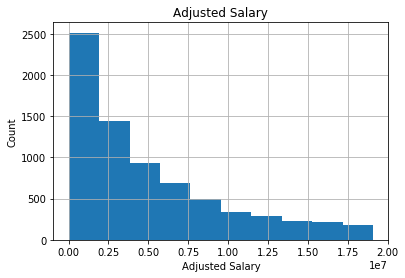

In [11]:
# plot the adjusted salary distribution
axarr = df.hist('SALARY_ADJ')
for ax in axarr.flatten():
    ax.set_xlabel('Adjusted Salary')
    ax.set_ylabel('Count')
    ax.set_title('Adjusted Salary')

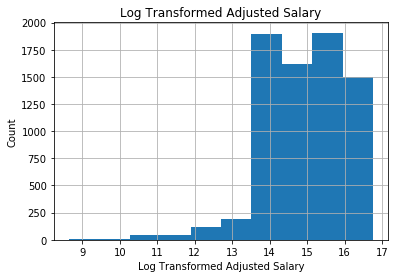

In [12]:
# take log transformation for salary
df['SALARY_LOG'] = np.log(df['SALARY_ADJ'])

# plot the log salary distribution
axarr = df.hist('SALARY_LOG')
for ax in axarr.flatten():
    ax.set_xlabel('Log Transformed Adjusted Salary')
    ax.set_ylabel('Count')
    ax.set_title('Log Transformed Adjusted Salary')

In [13]:
# label encode TEAM_ABBREVIATION to numbers
le = LabelEncoder()
le.fit(df['TEAM_ABBREVIATION'])
df['TEAM_ABBREVIATION'] = le.transform(df['TEAM_ABBREVIATION'])

In [14]:
# split features and raw target
X = df[[
    'GP', 'MIN', 'FG_PCT', 'FGM', 'FGA', 'FG3M', 'FG3A',
    'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 
    'REB', 'AST', 'BLK', 'STL', 'PF', 'TOV', 'PTS', 'YEAR', 'TEAM_ABBREVIATION']]
y = df['SALARY_ADJ']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
    test_size = 0.25, random_state = 57)

# transform features by scaling each feature to (0, 1)
mms = MinMaxScaler()
mms.fit(X)
X_train_scaled = mms.transform(X_train)
X_test_scaled = mms.transform(X_test)

In [15]:
# split features and log salary
X = df[[
    'GP', 'MIN', 'FG_PCT', 'FGM', 'FGA', 'FG3M', 'FG3A',
    'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 
    'REB', 'AST', 'BLK', 'STL', 'PF', 'TOV', 'PTS', 'YEAR', 'TEAM_ABBREVIATION']]
y = df['SALARY_LOG']

# train test split for log salary
X_log_train, X_log_test, y_log_train, y_log_test = train_test_split(X, y, 
    test_size = 0.25, random_state = 57)

# transform features by scaling each feature to (0, 1)
mms = MinMaxScaler()
mms.fit(X)
X_log_train_scaled = mms.transform(X_log_train)
X_log_test_scaled = mms.transform(X_log_test)

### Model

---

###### Linear Regression

In [16]:
# cross validation for Linear Regression
def lr_cv(X_tr, y_tr, X_te, y_te, n_splits = 5):

    # define kfold and loop through each iteration
    kf = KFold(n_splits = n_splits, shuffle = True, random_state = 57)

    # out of fold empty array
    oof = np.zeros(shape = (X_tr.shape[0]))
    # folds empty array
    folds = np.zeros(shape = (X_tr.shape[0]))
    # test empty array
    t_fold = np.zeros(shape = (X_te.shape[0]))

    # initial train, test and validation MAE
    mae_train = []
    mae_valid = []
    mae_test = []
    
    for ti, vi in kf.split(X_tr):
        
        # split train and valid dataframe
        train_features, train_labels = X_tr[ti], y_tr[ti]
        valid_features, valid_labels = X_tr[vi], y_tr[vi]

        X_const = sm.add_constant(train_features)
        model = sm.OLS(train_labels, X_const)
        res = model.fit()
        
        oof[vi] = res.predict(sm.add_constant(valid_features))
        folds[ti] = res.predict(X_const)
        t_fold += res.predict(sm.add_constant(X_te))
        
        # update MAE score for train and validation
        mae_train.append(mean_absolute_error(train_labels, folds[ti]))
        mae_valid.append(mean_absolute_error(valid_labels, oof[vi]))
    
    # update MAE score for test
    mae_test.append(mean_absolute_error(y_te, np.round(t_fold / n_splits)))
    
    return mae_train, mae_valid, mae_test, res

In [17]:
mae_train, mae_valid, mae_test, res = lr_cv(X_train_scaled,  y_train.values, 
                                       X_test_scaled, y_test.values, n_splits = 5)
print('Mean Absolute Error for training set is ', np.mean(mae_train))
print('Mean Absolute Error for validation set is ', np.mean(mae_valid))
print('Mean Absolute Error for testing set is ', np.mean(mae_test))
print('\nResult Summary:\n')
_ = print(res.summary2())

Mean Absolute Error for training set is  2630391.631107287
Mean Absolute Error for validation set is  2643527.538128403
Mean Absolute Error for testing set is  2657534.652467322

Result Summary:

                       Results: Ordinary least squares
Model:                 OLS                 Adj. R-squared:        0.412      
Dependent Variable:    y                   AIC:                   145222.6687
Date:                  2020-11-26 23:03    BIC:                   145369.6188
No. Observations:      4399                Log-Likelihood:        -72588.    
Df Model:              22                  F-statistic:           141.1      
Df Residuals:          4376                Prob (F-statistic):    0.00       
R-squared:             0.415               Scale:                 1.2661e+13 
-----------------------------------------------------------------------------
          Coef.        Std.Err.      t    P>|t|      [0.025         0.975]   
-----------------------------------------------

###### Linear Regression - Log Transformation

In [18]:
# cross validation for Linear Regression
def lr_log_cv(X_tr, y_tr, X_te, y_te, n_splits = 5):

    # define kfold and loop through each iteration
    kf = KFold(n_splits = n_splits, shuffle = True, random_state = 57)

    # out of fold empty array
    oof = np.zeros(shape = (X_tr.shape[0]))
    # folds empty array
    folds = np.zeros(shape = (X_tr.shape[0]))
    # test empty array
    t_fold = np.zeros(shape = (X_te.shape[0]))

    # initial train, test and validation MAE
    mae_train = []
    mae_valid = []
    mae_test = []
    
    for ti, vi in kf.split(X_tr):
        
        # split train and valid dataframe
        train_features, train_labels = X_tr[ti], y_tr[ti]
        valid_features, valid_labels = X_tr[vi], y_tr[vi]

        X_const = sm.add_constant(train_features)
        model = sm.OLS(train_labels, X_const)
        res = model.fit()
        
        oof[vi] = res.predict(sm.add_constant(valid_features))
        folds[ti] = res.predict(X_const)
        t_fold += res.predict(sm.add_constant(X_te))
        
        # update MAE score for train and validation
        mae_train.append(mean_absolute_error(np.e**train_labels, np.e**folds[ti]))
        mae_valid.append(mean_absolute_error(np.e**valid_labels, np.e**oof[vi]))
    
    # update MAE score for test
    mae_test.append(mean_absolute_error(np.e**y_te, np.e**(np.round(t_fold / n_splits))))
    
    return mae_train, mae_valid, mae_test, res

In [19]:
mae_train, mae_valid, mae_test, res = lr_log_cv(X_log_train_scaled,  y_log_train.values, 
                                       X_log_test_scaled, y_log_test.values, n_splits = 5)
print('Mean Absolute Error for training set is ', np.mean(mae_train))
print('Mean Absolute Error for validation set is ', np.mean(mae_valid))
print('Mean Absolute Error for testing set is ', np.mean(mae_test))
print('\nResult Summary:\n')
_ = print(res.summary2())

Mean Absolute Error for training set is  2608951.783782035
Mean Absolute Error for validation set is  2624046.5130878882
Mean Absolute Error for testing set is  2697610.44458294

Result Summary:

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.379     
Dependent Variable: y                AIC:                11236.5446
Date:               2020-11-26 23:03 BIC:                11383.4947
No. Observations:   4399             Log-Likelihood:     -5595.3   
Df Model:           22               F-statistic:        123.2     
Df Residuals:       4376             Prob (F-statistic): 0.00      
R-squared:          0.382            Scale:              0.74920   
---------------------------------------------------------------------
            Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
---------------------------------------------------------------------
const      13.5969     0.1260   107.8967   0.0000   13.3498   13.843

###### Random Forest

In [20]:
# cross validation for Random Forest
def rf_cv(X_tr, y_tr, X_te, y_te, n_splits = 5, n = 100):

    # define kfold and loop through each iteration
    kf = KFold(n_splits = n_splits, shuffle = True, random_state = 57)

    # out of fold empty array
    oof = np.zeros(shape = (X_tr.shape[0]))
    # folds empty array
    folds = np.zeros(shape = (X_tr.shape[0]))
    # test empty array
    t_fold = np.zeros(shape = (X_te.shape[0]))

    # initial train, test and validation MAE
    mae_train = []
    mae_valid = []
    mae_test = []
    
    for ti, vi in kf.split(X_tr):
        
        # split train and valid dataframe
        train_features, train_labels = X_tr.loc[ti], y_tr[ti]
        valid_features, valid_labels = X_tr.loc[vi], y_tr[vi]

        rf = RandomForestRegressor(n_estimators = n, max_depth = 7, random_state = 57)
        rf.fit(train_features, train_labels)
        
        oof[vi] = rf.predict(valid_features)
        folds[ti] = rf.predict(train_features)
        t_fold += rf.predict(X_te)
        
        # update MAE score for train and validation
        mae_train.append(mean_absolute_error(train_labels, folds[ti]))
        mae_valid.append(mean_absolute_error(valid_labels, oof[vi]))
    
    # update MAE score for test
    mae_test.append(mean_absolute_error(y_te, np.round(t_fold / n_splits)))
    
    return mae_train, mae_valid, mae_test

In [21]:
# grid search for best model based on MAE score
mae_train_list = []
mae_valid_list = []
mae_test_list = []
N = []
X_train.reset_index(drop = True, inplace = True)
for n in [50, 100, 150, 200]:
    mae_train, mae_valid, mae_test = rf_cv(X_train,  y_train.values, X_test, y_test.values, n_splits = 5, n = n)
    N.append(n)
    mae_train_list.append(np.mean(mae_train))
    mae_valid_list.append(np.mean(mae_valid))
    mae_test_list.append(mae_test)
    
print('Best Model:')
print('N = ', N[mae_valid_list.index(np.min(mae_valid_list))])
print('Training MAE: ', mae_train_list[mae_valid_list.index(np.min(mae_valid_list))])
print('Validation MAE: ', mae_valid_list[mae_valid_list.index(np.min(mae_valid_list))])
print('Testing MAE: ', mae_test_list[mae_valid_list.index(np.min(mae_valid_list))][0])

Best Model:
N =  150
Training MAE:  2217324.2576361643
Validation MAE:  2599302.363417224
Testing MAE:  2576967.6414939314


###### Random Forest - Log Transformation

In [22]:
# cross validation for Random Forest
def rf_log_cv(X_tr, y_tr, X_te, y_te, n_splits = 10, n = 100):

    # define kfold and loop through each iteration
    kf = KFold(n_splits = n_splits, shuffle = True, random_state = 57)

    # out of fold empty array
    oof = np.zeros(shape = (X_tr.shape[0]))
    # folds empty array
    folds = np.zeros(shape = (X_tr.shape[0]))
    # test empty array
    t_fold = np.zeros(shape = (X_te.shape[0]))

    # initial train, test and validation MAE
    mae_train = []
    mae_valid = []
    mae_test = []
    
    for ti, vi in kf.split(X_tr):
        
        # split train and valid dataframe
        train_features, train_labels = X_tr.loc[ti], y_tr[ti]
        valid_features, valid_labels = X_tr.loc[vi], y_tr[vi]

        rf = RandomForestRegressor(n_estimators = n, max_depth = 6, random_state = 57)
        rf.fit(train_features, train_labels)
        
        oof[vi] = rf.predict(valid_features)
        folds[ti] = rf.predict(train_features)
        t_fold += rf.predict(X_te)
        
        # update MAE score for train and validation
        mae_train.append(mean_absolute_error(np.e**train_labels, np.e**folds[ti]))
        mae_valid.append(mean_absolute_error(np.e**valid_labels, np.e**oof[vi]))
    
    # update MAE score for test
    mae_test.append(mean_absolute_error(np.e**y_te, np.e**(np.round(t_fold / n_splits))))
    
    return mae_train, mae_valid, mae_test

In [23]:
# grid search for best model based on MAE score
mae_train_list = []
mae_valid_list = []
mae_test_list = []
N = []
X_log_train.reset_index(drop = True, inplace = True)
for n in [150, 200, 250, 300]:
    mae_train, mae_valid, mae_test = rf_log_cv(X_log_train,  y_log_train.values, X_log_test, y_log_test.values, n_splits = 5, n = n)
    N.append(n)
    mae_train_list.append(np.mean(mae_train))
    mae_valid_list.append(np.mean(mae_valid))
    mae_test_list.append(mae_test)

print('Best Model:')
print('N = ', N[mae_valid_list.index(np.min(mae_valid_list))])
print('Training MAE: ', mae_train_list[mae_valid_list.index(np.min(mae_valid_list))])
print('Validation MAE: ', mae_valid_list[mae_valid_list.index(np.min(mae_valid_list))])
print('Testing MAE: ', mae_test_list[mae_valid_list.index(np.min(mae_valid_list))][0])

Best Model:
N =  200
Training MAE:  2420796.699509752
Validation MAE:  2614012.60731351
Testing MAE:  2683214.3503682013


###### XGBoost

In [24]:
# cross validation for XGBoost
def xgb_cv(X_tr, y_tr, X_te, y_te, n_splits = 5, n = 100):

    # define kfold and loop through each iteration
    kf = KFold(n_splits = n_splits, shuffle = True, random_state = 57)

    # out of fold empty array
    oof = np.zeros(shape = (X_tr.shape[0]))
    # folds empty array
    folds = np.zeros(shape = (X_tr.shape[0]))
    # test empty array
    t_fold = np.zeros(shape = (X_te.shape[0]))

    # initial train, test and validation MAE
    mae_train = []
    mae_valid = []
    mae_test = []
    
    for ti, vi in kf.split(X_tr):
        
        # split train and valid dataframe
        train_features, train_labels = X_tr.loc[ti], y_tr[ti]
        valid_features, valid_labels = X_tr.loc[vi], y_tr[vi]

        xgb_model = xgb.XGBRegressor(n_estimators = n, 
                                     objective ='reg:squarederror',
                                     max_depth = 5,
                                     random_state = 57)
        xgb_model.fit(train_features, train_labels)
        
        oof[vi] = xgb_model.predict(valid_features)
        folds[ti] = xgb_model.predict(train_features)
        t_fold += xgb_model.predict(X_te)
        
        # update MAE score for train and validation
        mae_train.append(mean_absolute_error(train_labels, folds[ti]))
        mae_valid.append(mean_absolute_error(valid_labels, oof[vi]))
    
    # update MAE score for test
    mae_test.append(mean_absolute_error(y_te, np.round(t_fold / n_splits)))
    
    return mae_train, mae_valid, mae_test

In [25]:
# grid search for best model based on MAE score
mae_train_list = []
mae_valid_list = []
mae_test_list = []
N = []
X_train.reset_index(drop = True, inplace = True)
for n in [50, 100, 150]:
    mae_train, mae_valid, mae_test = xgb_cv(X_train,  y_train.values, X_test, y_test.values, n_splits = 5, n = n)
    N.append(n)
    mae_train_list.append(np.mean(mae_train))
    mae_valid_list.append(np.mean(mae_valid))
    mae_test_list.append(mae_test)

print('Best Model:')
print('N = ', N[mae_valid_list.index(np.min(mae_valid_list))])
print('Training MAE: ', mae_train_list[mae_valid_list.index(np.min(mae_valid_list))])
print('Validation MAE: ', mae_valid_list[mae_valid_list.index(np.min(mae_valid_list))])
print('Testing MAE: ', mae_test_list[mae_valid_list.index(np.min(mae_valid_list))][0])

Best Model:
N =  100
Training MAE:  1805619.0055404957
Validation MAE:  2543037.3842429225
Testing MAE:  2506490.7989406576


###### XGBoost - Log Transformation

In [26]:
# cross validation for XGBoost
def xgb_log_cv(X_tr, y_tr, X_te, y_te, n_splits = 5, n = 100):

    # define kfold and loop through each iteration
    kf = KFold(n_splits = n_splits, shuffle = True, random_state = 57)

    # out of fold empty array
    oof = np.zeros(shape = (X_tr.shape[0]))
    # folds empty array
    folds = np.zeros(shape = (X_tr.shape[0]))
    # test empty array
    t_fold = np.zeros(shape = (X_te.shape[0]))

    # initial train, test and validation MAE
    mae_train = []
    mae_valid = []
    mae_test = []
    
    for ti, vi in kf.split(X_tr):
        
        # split train and valid dataframe
        train_features, train_labels = X_tr.loc[ti], y_tr[ti]
        valid_features, valid_labels = X_tr.loc[vi], y_tr[vi]

        xgb_model = xgb.XGBRegressor(n_estimators = n, 
                                     objective ='reg:squarederror',
                                     max_depth = 5,
                                     random_state = 57)
        xgb_model.fit(train_features, train_labels)
        
        oof[vi] = xgb_model.predict(valid_features)
        folds[ti] = xgb_model.predict(train_features)
        t_fold += xgb_model.predict(X_te)
        
        # update MAE score for train and validation
        mae_train.append(mean_absolute_error(np.e**train_labels, np.e**folds[ti]))
        mae_valid.append(mean_absolute_error(np.e**valid_labels, np.e**oof[vi]))
    
    # update MAE score for test
    mae_test.append(mean_absolute_error(np.e**y_te, np.e**(np.round(t_fold / n_splits))))
    
    return mae_train, mae_valid, mae_test

In [27]:
# grid search for best model based on MAE score
mae_train_list = []
mae_valid_list = []
mae_test_list = []
N = []
X_log_train.reset_index(drop = True, inplace = True)
for n in [50, 100, 150, 200]:
    mae_train, mae_valid, mae_test = xgb_log_cv(X_log_train,  y_log_train.values, X_log_test, y_log_test.values, n_splits = 5, n = n)
    N.append(n)
    mae_train_list.append(np.mean(mae_train))
    mae_valid_list.append(np.mean(mae_valid))
    mae_test_list.append(mae_test)

print('Best Model:')
print('N = ', N[mae_valid_list.index(np.min(mae_valid_list))])
print('Training MAE: ', mae_train_list[mae_valid_list.index(np.min(mae_valid_list))])
print('Validation MAE: ', mae_valid_list[mae_valid_list.index(np.min(mae_valid_list))])
print('Testing MAE: ', mae_test_list[mae_valid_list.index(np.min(mae_valid_list))][0])

Best Model:
N =  100
Training MAE:  2028077.6647273072
Validation MAE:  2567475.667569154
Testing MAE:  2658717.4650750044


After comparint the models' performance, we select XGBRegressor predicting Adjusted salary as our final model. The model has testing mean absolute error of 2,506,490.

### Feature Importance

---

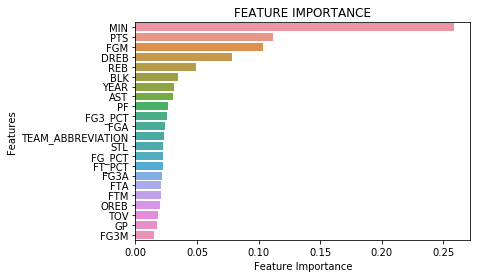

In [36]:
# select the best performance model
xgb_model = xgb.XGBRegressor(n_estimators = 100, max_depth = 5, 
                             objective ='reg:squarederror', random_state = 57)
xgb_model.fit(X_train,  y_train.values)

# dataframe for feature importance and feature names
feature_importance = np.array(xgb_model.feature_importances_)
features = np.array(X_train.columns)
fi_df = pd.DataFrame({'features':features,'feature_importance':feature_importance})

# sort the dataframe by feature importance
fi_df.sort_values(by=['feature_importance'], ascending = False , inplace = True)


# plot bar chart
sns.barplot(fi_df['feature_importance'], fi_df['features'])
plt.title('FEATURE IMPORTANCE')
plt.xlabel('Feature Importance')
_ = plt.ylabel('Features')

The top three important features are minutes played per game, points per game and field goal made per game.

### Reasons of Large MAE

---

In [37]:
# make predictions for X_test
pred = pd.DataFrame({'prediction': xgb_model.predict(X_test)})
X_test_temp = X_test.reset_index(drop = True)
y_test_temp = y_test.reset_index(drop = True)

In [38]:
# compute the difference of actual salary and prediction
result = pd.concat([X_test_temp, pred, y_test_temp], axis = 1)
result['diff'] = result['SALARY_ADJ'] - result['prediction']
result['diff'].describe()

count    1.833000e+03
mean    -1.139099e+05
std      3.449223e+06
min     -1.099371e+07
25%     -1.956912e+06
50%     -5.993710e+05
75%      1.340231e+06
max      1.476059e+07
Name: diff, dtype: float64

In [64]:
# stats of Top three important features
result.describe()[['MIN', 'PTS', 'FGM']].round()

,MIN,PTS,FGM
count,1833.0,1833.0,1833.0
mean,21.0,8.0,3.0
std,9.0,5.0,2.0
min,1.0,0.0,0.0
25%,14.0,4.0,2.0
50%,21.0,7.0,3.0
75%,28.0,11.0,4.0
max,42.0,32.0,11.0


In [39]:
# get top 10 observations with the most salary and prediction difference

# create name list
names = []
# get player names
for i in result.sort_values('diff').index[-10:].values:
    j = int(X_test[i:i+1].index.values)
    names.append(df[j:j + 1]['PLAYER_NAME'].values[0])

# create top 10 overvalued paler dataframe
top_10_overvalued = result.sort_values('diff')[-10:].reset_index(drop = True)
names = pd.DataFrame({'PLAYER_NAME': names})
top_10_overvalued = pd.concat([names, top_10_overvalued], axis = 1)

In [61]:
top_10_overvalued[['PLAYER_NAME', 'MIN', 'PTS', 'FGM', 
                   'YEAR', 'SALARY_ADJ', 'prediction', 'diff']].sort_values(
    by = 'diff', ascending = False).reset_index(drop = True).round()

,PLAYER_NAME,MIN,PTS,FGM,YEAR,SALARY_ADJ,prediction,diff
0,Paul George,15.0,9.0,3.0,2014,18642783.0,3882196.0,14760588.0
1,Jeff Teague,25.0,11.0,4.0,2019,19000000.0,4691902.0,14308098.0
2,Shawn Kemp,16.0,6.0,2.0,2000,18602786.0,4671933.0,13930853.0
3,Raef LaFrentz,13.0,4.0,1.0,2006,15477536.0,2149181.0,13328355.0
4,Ian Mahinmi,18.0,6.0,2.0,2016,16786903.0,4153729.0,12633174.0
5,Brandon Knight,19.0,7.0,2.0,2018,15800188.0,3394975.0,12405212.0
6,Gary Harris,29.0,13.0,5.0,2018,18017679.0,5641946.0,12375733.0
7,Gary Harris,32.0,10.0,4.0,2019,17839286.0,5830866.0,12008420.0
8,Elton Brand,30.0,13.0,5.0,2009,18902182.0,7039169.0,11863013.0
9,Nick Collison,21.0,6.0,2.0,2009,15717175.0,4020148.0,11697027.0


Potential reasons why some palyers are overvalued:

1. Some of the players may have contracts with the teams for several consecutive years, where the salaries do not change a lot by their performance.
2. Although some players do not have fancy stats in some seasons, the team coach sees their potential or thinks they may be a good fit for the whole team. For example, Jeff Teague suffers from ankle and knee injury but still has a decent salary.
3. Players who are super famous tend to have higher salaries.

In [41]:
# get top 10 observations with the most prediction and salary difference

# create name list
names = []
for i in result.sort_values('diff').index[:10].values:
    j = int(X_test[i:i+1].index.values)
    names.append(df[j:j + 1]['PLAYER_NAME'].values[0])
    
# create top 10 undervalued paler dataframe
top_10_undervalued = result.sort_values('diff')[:10].reset_index(drop = True)
names = pd.DataFrame({'PLAYER_NAME': names})
top_10_undervalued = pd.concat([names, top_10_undervalued], axis = 1)

In [62]:
top_10_undervalued[['PLAYER_NAME', 'MIN', 'PTS', 'FGM', 'YEAR', 'SALARY_ADJ', 'prediction', 'diff']].round()

,PLAYER_NAME,MIN,PTS,FGM,YEAR,SALARY_ADJ,prediction,diff
0,Joe Johnson,35.0,14.0,6.0,2014,285187.0,11278896.0,-10993709.0
1,Chris Bosh,39.0,22.0,8.0,2005,5416554.0,15823448.0,-10406894.0
2,Derrick Rose,32.0,18.0,7.0,2016,306330.0,10359596.0,-10053266.0
3,John Collins,33.0,22.0,9.0,2019,2686560.0,12435296.0,-9748736.0
4,Giannis Antetokounmpo,35.0,17.0,6.0,2015,3219977.0,12560490.0,-9340513.0
5,Lamar Odom,37.0,17.0,6.0,2000,4096401.0,13377620.0,-9281219.0
6,Greivis Vasquez,34.0,14.0,6.0,2012,2381269.0,11637802.0,-9256533.0
7,Brandon Roy,38.0,19.0,7.0,2007,3696620.0,12897720.0,-9201100.0
8,Josh Smith,37.0,16.0,6.0,2006,2791183.0,11805666.0,-9014483.0
9,Russell Westbrook,35.0,22.0,8.0,2010,5833028.0,14833960.0,-9000932.0


Potential reasons why some palyers are undervalued:

1. Some of the players have good performance, but they are new to NBA. For example, Chris Bosh was a new player in 2005. That's why he had a low salary but great performance. His salary goes up to 13 million in 2007.

2. Official NBA website doesn't contain salary data so that we can only get the data from third party websites. There are some discrepancies between those websites. For example, Joe Johnson has raw salary 261,894 reported by ESPN, while hoopshype reports 21,894,863.

Quantifying or collecting the potential features stated above is not feasible. We conclude that player performance data plays a very import role in predicting salary but the model could be improved by introduing new features and compare data between several third party websites.

Besides, our model can be used to determine whether a player is overvalued or undervalued based on his previous year's performance and current year's salary.

* [Go back to table of contents](#main)

---

---

<a class='anchor' id='section3'></a>
<a class='anchor' id='section_3_1'></a>

## 3. Team

## 3.1 Team Valuation on NBA Data

The goal of this section is to perform PCA and hypothesis testing of the NBA official team statistics data.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA 

In [2]:
team_data_path = 'nba_team_stats_official.csv'
data = pd.read_csv(team_data_path)
data.head()

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,...,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,CFID,CFPARAMS,year
0,1610612737,Atlanta Hawks,82,56,26,0.683,48.3,34.3,76.9,0.446,...,9,11,4,1,27,23,5,10,Atlanta Hawks,1996-97
1,1610612738,Boston Celtics,82,15,67,0.183,48.5,37.4,85.0,0.440,...,2,27,29,22,21,5,27,10,Boston Celtics,1996-97
2,1610612766,Charlotte Hornets,82,54,28,0.659,48.3,36.4,77.3,0.471,...,26,22,6,6,9,12,11,10,Charlotte Hornets,1996-97
3,1610612741,Chicago Bulls,82,69,13,0.841,48.1,40.0,84.4,0.473,...,7,25,2,3,7,1,1,10,Chicago Bulls,1996-97
4,1610612739,Cleveland Cavaliers,82,42,40,0.512,48.4,33.0,72.8,0.453,...,16,27,7,19,4,29,12,10,Cleveland Cavaliers,1996-97


In [3]:
data.columns

Index(['TEAM_ID', 'TEAM_NAME', 'GP', 'W', 'L', 'W_PCT', 'MIN', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS',
       'PLUS_MINUS', 'GP_RANK', 'W_RANK', 'L_RANK', 'W_PCT_RANK', 'MIN_RANK',
       'FGM_RANK', 'FGA_RANK', 'FG_PCT_RANK', 'FG3M_RANK', 'FG3A_RANK',
       'FG3_PCT_RANK', 'FTM_RANK', 'FTA_RANK', 'FT_PCT_RANK', 'OREB_RANK',
       'DREB_RANK', 'REB_RANK', 'AST_RANK', 'TOV_RANK', 'STL_RANK', 'BLK_RANK',
       'BLKA_RANK', 'PF_RANK', 'PFD_RANK', 'PTS_RANK', 'PLUS_MINUS_RANK',
       'CFID', 'CFPARAMS', 'year'],
      dtype='object')

In [4]:
data.isnull().sum()

TEAM_ID            0
TEAM_NAME          0
GP                 0
W                  0
L                  0
W_PCT              0
MIN                0
FGM                0
FGA                0
FG_PCT             0
FG3M               0
FG3A               0
FG3_PCT            0
FTM                0
FTA                0
FT_PCT             0
OREB               0
DREB               0
REB                0
AST                0
TOV                0
STL                0
BLK                0
BLKA               0
PF                 0
PFD                0
PTS                0
PLUS_MINUS         0
GP_RANK            0
W_RANK             0
L_RANK             0
W_PCT_RANK         0
MIN_RANK           0
FGM_RANK           0
FGA_RANK           0
FG_PCT_RANK        0
FG3M_RANK          0
FG3A_RANK          0
FG3_PCT_RANK       0
FTM_RANK           0
FTA_RANK           0
FT_PCT_RANK        0
OREB_RANK          0
DREB_RANK          0
REB_RANK           0
AST_RANK           0
TOV_RANK           0
STL_RANK     

#### No null values that we need to deal with.

In [5]:
metrics = ['MIN', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS',
       'PLUS_MINUS']

def standardize_data(data):
    '''
    for each column, subtract mean and divide by standard deviation
    '''
    
    ans = (data-data.mean())/data.std()
    old_cols = data.columns
    new_cols = [c+"_SD" for c in old_cols]
    ans.columns = new_cols
    return ans

data_metrics_sd = standardize_data(data[metrics])

In [6]:
data_metrics_sd

,MIN_SD,FGM_SD,FGA_SD,FG_PCT_SD,FG3M_SD,FG3A_SD,FG3_PCT_SD,FTM_SD,FTA_SD,FT_PCT_SD,...,REB_SD,AST_SD,TOV_SD,STL_SD,BLK_SD,BLKA_SD,PF_SD,PFD_SD,PTS_SD,PLUS_MINUS_SD
0,-0.318206,-1.255016,-1.365446,-0.383667,0.433160,0.438294,0.303526,-0.052312,-0.177261,0.260513,...,-0.641614,-1.428021,0.303121,0.883600,0.332836,-1.295134,-1.049258,-1.324582,-0.728370,1.177223
1,0.803392,0.118550,0.755884,-0.755328,-0.468853,-0.464470,-0.130334,0.930569,0.974287,-0.170848,...,-1.177055,-0.020384,1.469728,2.422336,-1.348720,2.625867,1.226145,-1.324582,0.176854,-1.588482
2,-0.318206,-0.324536,-1.260689,1.164920,0.119416,-0.362545,3.581585,0.258072,-0.023721,0.725055,...,-1.615144,1.290175,0.053134,-0.435317,-0.748164,-1.155098,-0.252867,-1.314484,-0.088471,0.415021
3,-1.439804,1.270574,0.598748,1.288807,-0.194327,-0.333424,0.930214,-0.776540,-0.676265,-0.270393,...,1.305447,2.018264,-0.946815,1.103420,-1.108497,-1.995313,-0.878602,-1.314484,0.567036,2.353192
4,0.242593,-1.831028,-2.439206,0.049938,-0.390417,-0.537274,1.074834,-1.397307,-1.021730,-1.066751,...,-2.442645,-0.505776,-0.113524,0.334051,-1.348720,-0.875027,0.998604,-1.314484,-1.867704,0.393244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,0.803392,1.669352,1.646319,0.607429,2.276403,2.258384,0.496353,-1.345576,-1.520734,0.492784,...,0.088534,0.901862,-0.113524,0.004322,-0.988386,-1.015062,0.543524,0.634429,1.659548,-0.434290
708,0.803392,2.245364,1.908211,1.226864,1.492044,1.326498,1.074834,0.361533,-0.330801,1.820047,...,1.062064,1.338715,-1.696776,-0.435317,0.693169,-0.875027,-1.049258,0.695017,2.283840,-0.238295
709,-0.318206,1.359191,1.515372,0.359655,2.707801,2.564159,0.978421,0.102880,-0.407570,1.355505,...,1.451476,1.581411,0.136463,1.213329,0.092614,0.805402,0.259099,0.725311,2.080945,1.351440
710,-0.879005,1.314883,0.782073,1.164920,2.550929,2.302066,1.267661,-0.259234,-0.561110,0.791418,...,1.208094,0.222312,0.386450,-1.754233,-0.988386,-0.454919,-0.480407,0.765703,1.846836,0.545684


## PCA
- see which dataset features are the most important

In [7]:
def run_pca(data, n_components=10):
    '''
    given data and the number of principal components to extract, extract the pca and the factor loadings
    returns:
        pca, loadings
    '''
    
    pca = PCA(n_components=n_components)
    pca.fit_transform(data)
    
    # loadings
    a = pca.components_.T * np.sqrt(pca.explained_variance_)
    loadings = pd.DataFrame(a).round(3)
    loadings.index = data_metrics_sd.columns
    loadings.columns = ['pc'+str(i+1) for i in range(n_components)]
    
    print('explained variance per principal component:',pca.explained_variance_ratio_)
    print('total explained variance:',np.sum(pca.explained_variance_ratio_))
    
    return pca, loadings

explained variance per principal component: [0.32247944 0.11970697 0.11701209 0.07084364 0.06199939]
total explained variance: 0.6920415393517508


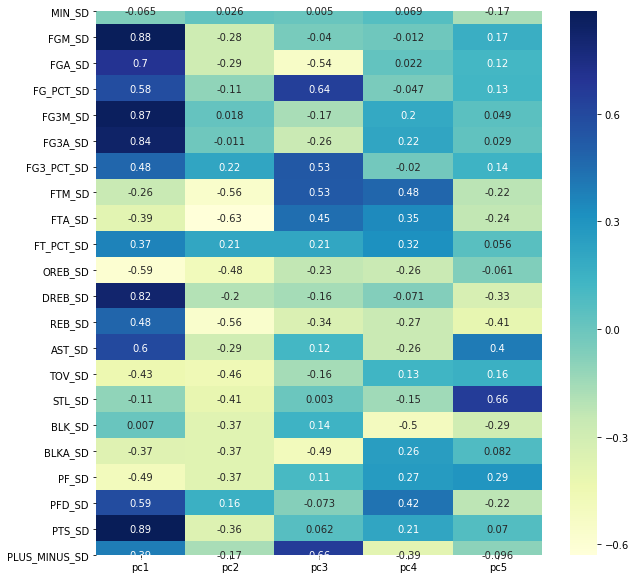

In [8]:
# run PCA on all teams data
pca_all, loadings_all = run_pca(data_metrics_sd, 5)


fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(ax=ax,data=loadings_all, annot=True, cmap="YlGnBu")


### Insights:
- PC1 (32%) "Shooting":
    - field goals made and attempted, 3 pointers taken and made
    - defensive rebounds
    - points
- PC2 (12%) "Second Chance Opportunities":
    - negative correlation with free throws attempted and made
    - negative correlation with rebounds (mostly offensive)
- PC3 (12%) "Clutch":
    - pos corr w/ plus-minus
    - pos corr w/ field goal percentage, and fewer attempts
    - negative correlation with attempts
    - negative correlation with blocks against
- PC4 (7%) "Small Ball":
    - positive correlation w/ free throws made
    - negative correlation w/ blocks
- PC5 (6%) "Passing":
    - steals and assists
    
PC1 seems to capture scoring ability. PC2 captures the inability to draw fouls and get rebounds, specifically offensive rebounds. PC3 talks about fewer, better quality shooting attempts and having a greater plus-minus. It looks like PC3 is talking about fewer shots, but better shots and from 3 point range. PC4 mentions converting free throws and not getting any blocks. PC5 is highly correlated with completing passes (assists) and intercepting passes (steals).

    

## Investigate best NBA teams from each season
- consider top 5 from each season (based on games won)
- perform PCA and see how it compares to the PCA above
- calculate how far away a team is from a top team in terms of stats

Questions:
1. What are the factors that top teams have in common?
2. Are teams becoming better each year?


### 1. What are the factors that top teams have in common?

In [9]:
def fix_year(data):
    '''
    fixes year format from string 'YYYY-YY' (e.g. '2004-05') to be an integer YYYY (e.g. 2004)
    returns:
        data with fixed year
    '''
    ans = data.copy()
    ans.year = [int(s[:4]) for s in ans.year.values]
    return ans

data = fix_year(data)

In [10]:
def top_5_per_year(data):
    '''
    extracts the top 5 teams per year based on total wins
    '''
    # W
    years = data.year.unique()
    
    ans = pd.DataFrame({})
    
    for y in years:
        temp = data[data.year == y]
        temp = temp.sort_values('W', ascending=False).head()
        ans = pd.concat([ans, temp], axis=0)
    
    return ans
        
top5_data = top_5_per_year(data)

In [11]:
top5_data.head()

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,...,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,CFID,CFPARAMS,year
3,1610612741,Chicago Bulls,82,69,13,0.841,48.1,40.0,84.4,0.473,...,7,25,2,3,7,1,1,10,Chicago Bulls,1996
26,1610612762,Utah Jazz,82,64,18,0.780,48.4,38.2,75.8,0.504,...,3,12,10,28,6,2,2,10,Utah Jazz,1996
13,1610612748,Miami Heat,82,61,21,0.744,48.3,34.4,76.0,0.453,...,18,8,12,23,3,22,4,10,Miami Heat,1996
24,1610612760,Seattle SuperSonics,82,57,25,0.695,48.2,36.5,78.2,0.467,...,1,16,18,14,14,4,3,10,Seattle SuperSonics,1996
9,1610612745,Houston Rockets,82,57,25,0.695,48.4,37.0,79.1,0.468,...,11,24,8,2,9,5,7,10,Houston Rockets,1996


In [12]:
top5_sd = standardize_data(top5_data[metrics])

In [13]:
top5_sd.describe()

,MIN_SD,FGM_SD,FGA_SD,FG_PCT_SD,FG3M_SD,FG3A_SD,FG3_PCT_SD,FTM_SD,FTA_SD,FT_PCT_SD,...,REB_SD,AST_SD,TOV_SD,STL_SD,BLK_SD,BLKA_SD,PF_SD,PFD_SD,PTS_SD,PLUS_MINUS_SD
count,1.200000e+02,1.200000e+02,1.200000e+02,1.200000e+02,1.200000e+02,1.200000e+02,1.200000e+02,1.200000e+02,1.200000e+02,1.200000e+02,...,1.200000e+02,1.200000e+02,1.200000e+02,1.200000e+02,1.200000e+02,1.200000e+02,1.200000e+02,1.200000e+02,1.200000e+02,1.200000e+02
mean,6.703897e-14,2.224147e-15,-1.931788e-15,-2.834307e-15,-1.387779e-16,-3.682240e-16,9.475754e-15,-2.940935e-15,3.890407e-15,-4.505655e-15,...,1.877572e-14,6.833076e-16,1.887379e-16,2.504941e-15,1.512679e-15,-1.132427e-15,-2.524832e-15,-7.919591e-16,5.125530e-16,1.457197e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.276820e+00,-2.418792e+00,-2.521382e+00,-2.574605e+00,-1.706623e+00,-1.692140e+00,-2.417981e+00,-2.317486e+00,-2.492961e+00,-2.536360e+00,...,-2.915108e+00,-2.131060e+00,-2.559352e+00,-2.216036e+00,-1.808391e+00,-2.050509e+00,-2.117808e+00,-1.313925e+00,-2.042869e+00,-2.212993e+00
25%,-6.875184e-01,-6.553447e-01,-7.894617e-01,-6.298199e-01,-7.325693e-01,-6.794526e-01,-6.131214e-01,-6.748498e-01,-7.140394e-01,-4.997073e-01,...,-6.161391e-01,-6.695230e-01,-5.632842e-01,-8.061599e-01,-7.030926e-01,-8.007633e-01,-6.820950e-01,-1.296325e+00,-7.614432e-01,-7.729253e-01
50%,-9.821692e-02,-8.852227e-02,-2.447943e-02,-2.626578e-02,-1.759674e-01,-2.380248e-01,-2.919626e-02,-7.254978e-02,-4.694377e-02,1.694786e-01,...,-2.695608e-02,-4.315013e-02,-2.003628e-01,-1.012219e-01,-2.763246e-02,3.240083e-02,-9.834369e-02,6.773274e-01,-1.282682e-01,-2.622346e-02
75%,4.910846e-01,6.042607e-01,6.487050e-01,5.940537e-01,5.545727e-01,4.111337e-01,6.608971e-01,6.392594e-01,5.923562e-01,6.349992e-01,...,5.160165e-01,5.936623e-01,7.296232e-01,7.121682e-01,6.478277e-01,6.225587e-01,6.747324e-01,7.678388e-01,5.388269e-01,5.738048e-01
max,4.026894e+00,2.493669e+00,2.325546e+00,2.522074e+00,2.920131e+00,3.189532e+00,2.518841e+00,3.376987e+00,3.251474e+00,2.031561e+00,...,3.924036e+00,3.046956e+00,2.249356e+00,3.423468e+00,3.472479e+00,3.226196e+00,3.183285e+00,1.059487e+00,2.434583e+00,2.853912e+00


#### PCA

In [14]:
top5_sd

,MIN_SD,FGM_SD,FGA_SD,FG_PCT_SD,FG3M_SD,FG3A_SD,FG3_PCT_SD,FTM_SD,FTA_SD,FT_PCT_SD,...,REB_SD,AST_SD,TOV_SD,STL_SD,BLK_SD,BLKA_SD,PF_SD,PFD_SD,PTS_SD,PLUS_MINUS_SD
3,-1.276820,0.814195,0.685424,0.443165,-0.454268,-0.484705,0.236224,-1.058132,-0.825222,-0.354232,...,0.874147,1.251354,-0.654015,0.929072,-1.685580,-1.356206,-0.603210,-1.293811,0.082790,2.427226
26,0.491085,0.058432,-1.419807,2.522074,-1.254384,-1.276678,0.076972,2.172387,1.769039,0.285859,...,-1.390164,1.543661,1.069862,1.362880,-0.334660,0.032401,2.173553,-1.293811,0.082790,1.360509
13,-0.098217,-1.537068,-1.370848,-0.898066,0.206696,0.242353,-0.241533,-0.565341,-0.009883,-1.168893,...,-1.020480,-0.794798,1.523514,0.061456,0.033773,0.448983,1.731796,-1.283754,-1.168484,-0.399574
24,-0.687518,-0.655345,-0.832301,0.040796,-0.315118,-0.199075,-0.825458,1.241559,1.213126,-0.208757,...,-1.482585,0.165641,0.706941,3.423468,-0.825904,1.004426,0.848280,-1.293811,-0.248873,0.773814
9,0.491085,-0.445410,-0.611986,0.107857,0.171909,0.203403,-0.188449,-0.236813,-0.158126,-0.121472,...,-0.281113,0.583223,2.158626,0.603716,-1.439958,0.032401,-0.666318,-1.293811,-0.294100,-0.932933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,-0.687518,2.199761,2.276587,0.644350,2.120016,2.345626,-0.719290,-0.236813,-0.009883,-0.499707,...,3.924036,1.167837,0.797671,-0.697708,0.647828,0.032401,-0.666318,0.868407,2.434583,2.053875
709,-0.098217,0.898169,1.542204,-0.562758,2.120016,2.098946,0.289308,-0.127304,-0.565796,1.071425,...,1.012779,0.875530,0.525480,1.037524,-0.457471,1.421008,0.658955,0.737668,1.545123,-0.026223
695,-1.276820,1.779892,1.640122,0.912596,1.145962,1.397855,-1.037794,-0.565341,-0.158126,-0.877943,...,1.151410,0.959046,0.888401,0.820620,1.507504,-1.078485,0.027873,0.868407,1.635577,-0.239567
694,-0.098217,1.485984,1.860437,-0.026266,1.632989,1.644535,0.130056,1.132050,0.583091,0.925950,...,2.075618,0.249157,0.344019,-0.806160,-0.825904,0.310122,0.911388,0.989089,2.072769,0.080448


In [15]:
# run PCA on top 5 of teams of each season, approximately top 15% of teams.
top5_pca, top5_loadings = run_pca(top5_sd)

explained variance per principal component: [0.31972458 0.13020561 0.10195598 0.07372092 0.06856767 0.05392901
 0.04560334 0.04024321 0.03648109 0.02807241]
total explained variance: 0.8985038488709906


#### PCA Heatmap

Text(0.5, 1, 'Principal Component Correlation Matrix')

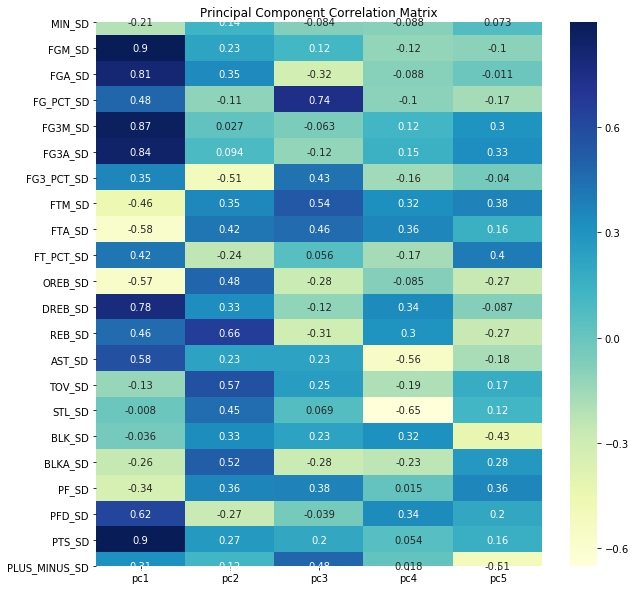

In [16]:
# plot heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(ax=ax,data=top5_loadings.iloc[:,:5], annot=True, cmap="YlGnBu")
ax.set_title('Principal Component Correlation Matrix')

Principal component descriptions:
1. PC1 (32%) "Shooting":
    - strong positive correlation (>0.85) with FGA, FGM, FG3A, FG3M
    - taking lots of shots to make lots of shots
    - 0.9 correlation with points (this makes sense)
    - DREB are strong positive correlated (0.78)
    - FT are less important (negative correlation)
    - Offensive rebounds are less important
    - high personal fouls drawn
    - Field goal percentage and 3pt percentage are less important
2. PC2 (13%) "Second Chance Opportunities"
    - positive: rebounds, turnovers, blocks against
    - negative: 3pt %
3. PC3 (10%) "Clutch"
    - field goal percentage
    - free throws made and attempted
    - plus-minus
4. PC4 (7.3%) "Small Ball"
    - nothing strong positive
    - negative: steals
5. PC5 (6.8%) "Passing"
    - nothing positive
    - negative plus-minus




#### PCA on average teams

In [17]:
# Perform PCA on the not top 5 teams
def bottom_teams_per_year(data):
    '''
    extracts the bottom 25 teams per year based on total wins
    '''
    # W
    years = data.year.unique()
    
    ans = pd.DataFrame({})
    
    for y in years:
        temp = data[data.year == y]
        m, n = temp.shape
        temp = temp.sort_values('W', ascending=True).head(m-5)
        ans = pd.concat([ans, temp], axis=0)
    
    return ans
average_teams = bottom_teams_per_year(data)

In [18]:
avg_team_sd = standardize_data(average_teams[metrics])

In [19]:
avg_team_pca, avg_team_loadings = run_pca(avg_team_sd)


explained variance per principal component: [0.3174584  0.12172046 0.11170801 0.06864994 0.06171138 0.0478498
 0.04404819 0.0430711  0.03637536 0.0335133 ]
total explained variance: 0.8861059471321985


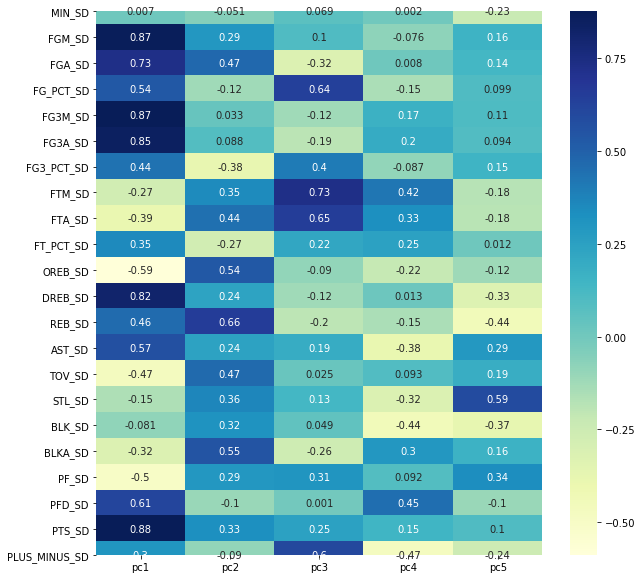

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(ax=ax,data=avg_team_loadings.iloc[:,:5], annot=True, cmap="YlGnBu")

Principal component descriptions
- PC1 (32%) "Shooting"
    - fg attempted and made
    - 3pts attempted and made
    - dreb
    - points
    - personal fouls drawn
    - ability to score points
- PC2 (12%) "Second Chance Opportunities"
    - rebounds, offensive
    - blocks against
    - turnovers
    - inability to convert on shots and losing possession
- PC3 (11%) "Clutch"
    - fg percentage
    - ft attempted and made
    - plus-minus
    - clutch moments
- PC4 (7%) "Small Ball"
    - negative blocks, +/-
    - positive ft attempted and made
- PC5 (6%) "Desperation"
    - increase steals at the expense of defense and blocks

PC5 is desperation instead of passing because we can see only a 0.29 correlation between with assists. We can also see that it has a negative correlation with blocks (-0.37) and a negative correlation with rebounds (-0.44), specifically defensive rebounds (-0.33). As a result, this demonstrates a team that is getting more steals at the expense of blocks and rebounds and therefore, we labelled it has "Desperation".

In [21]:
# blka must be blocks against. Verified by comparing to https://www.teamrankings.com/nba/stat/opponent-blocks-per-game
data[data.year == 2019][['TEAM_NAME', 'BLKA', 'year']].head()

,TEAM_NAME,BLKA,year
682,Atlanta Hawks,6.4,2019
683,Boston Celtics,5.5,2019
684,Brooklyn Nets,5.3,2019
685,Charlotte Hornets,5.0,2019
686,Chicago Bulls,5.9,2019


### 2. Are teams becoming better each year?
- check key metrics over time
- how are the best teams changing over the years?
    - see how the average of the top 5 teams are changing over the years

In [22]:
def avg_stat_per_year(data, stat='W'):
    '''
    given data and a stat, return the years and average value of the stat for each year
    '''
    years = data.year.unique()
    stats = [np.mean(data[data.year == y][stat].values) for y in years]
    return years, stats


In [23]:
print(len(metrics))

22


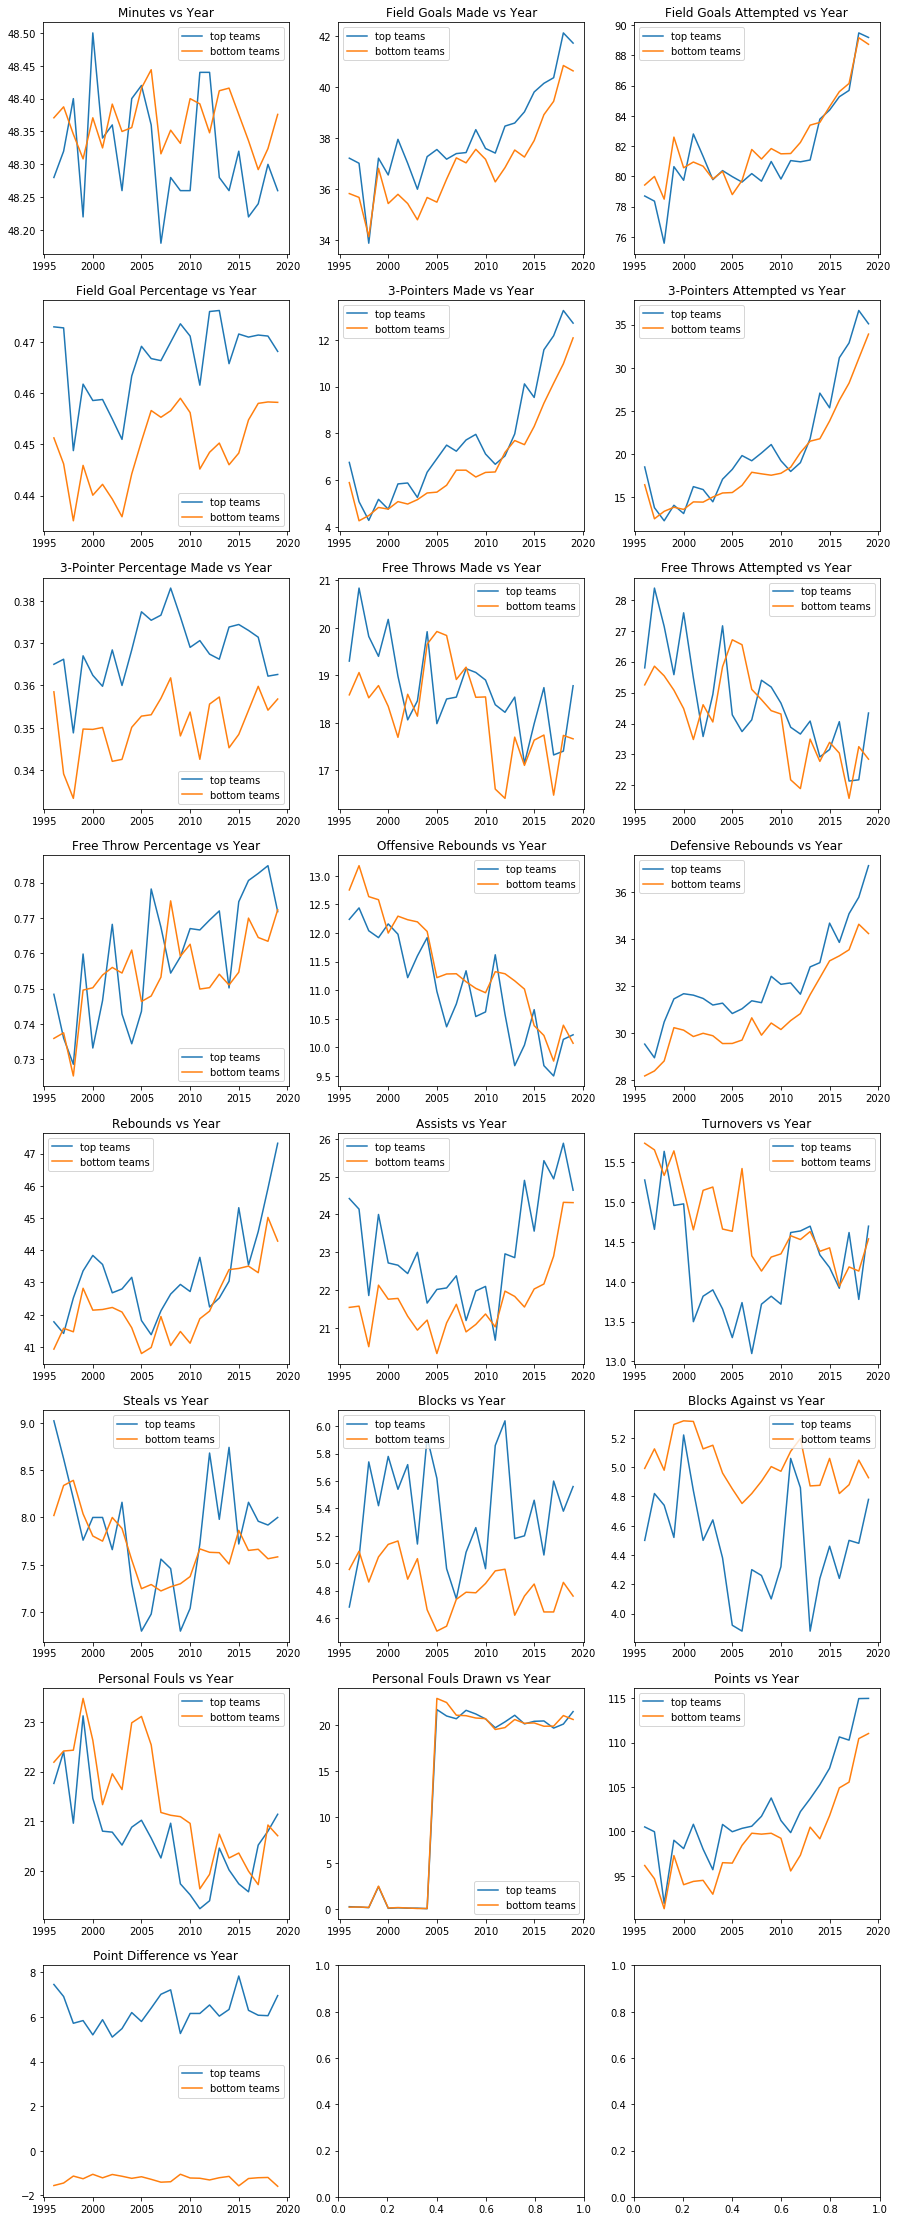

In [24]:
fig, axs = plt.subplots(8, 3, figsize=(15,40))


mapping = {
    'MIN': 'Minutes',
     'FGM': 'Field Goals Made',
     'FGA': 'Field Goals Attempted',
     'FG_PCT': 'Field Goal Percentage',
     'FG3M': '3-Pointers Made',
     'FG3A': '3-Pointers Attempted',
     'FG3_PCT':'3-Pointer Percentage Made',
     'FTM':'Free Throws Made',
     'FTA':'Free Throws Attempted',
     'FT_PCT': 'Free Throw Percentage',
     'OREB': 'Offensive Rebounds',
     'DREB': 'Defensive Rebounds',
     'REB': 'Rebounds',
     'AST': 'Assists',
     'TOV':'Turnovers',
     'STL': 'Steals',
     'BLK': 'Blocks',
     'BLKA': 'Blocks Against',
     'PF': 'Personal Fouls',
     'PFD': 'Personal Fouls Drawn',
     'PTS': 'Points',
     'PLUS_MINUS': 'Point Difference'
}




for i, stat in enumerate(metrics):
    
    # create figures
    #fig, ax1 = plt.subplots(1, 1, figsize=(20,10))
    
    a = i//3
    b = i%3
    
    # plot top teams
    x, y = avg_stat_per_year(top5_data, stat=stat)
    x1, y1 = avg_stat_per_year(average_teams, stat=stat)
    axs[a,b].plot(x,y)
    axs[a,b].plot(x1,y1)
    axs[a,b].set_title(mapping.get(stat)+" vs Year")
    axs[a,b].legend(['top teams', 'bottom teams'])
    



### Plot subset of graphs

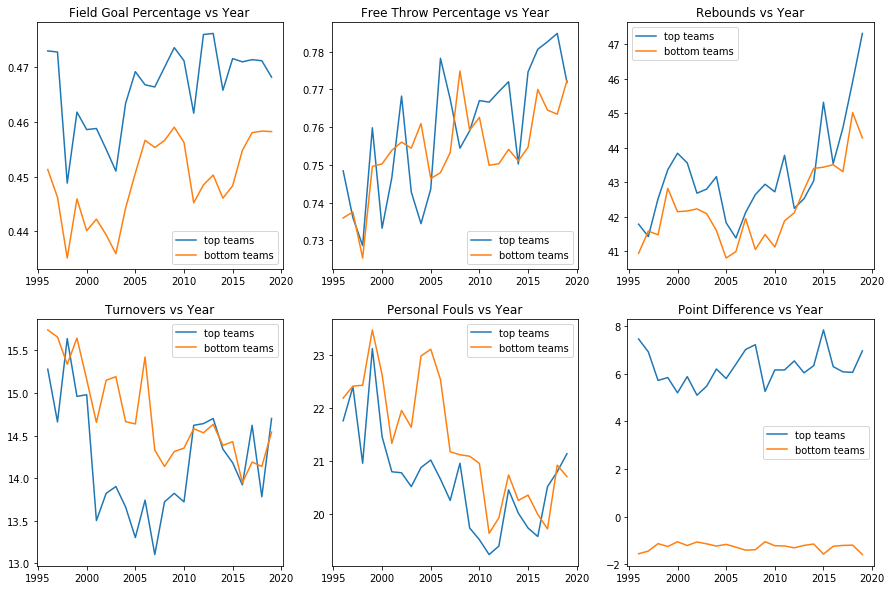

In [25]:
subset = [
    'FG_PCT', 
          'FT_PCT', 
          'REB', 
          'TOV', 
          'PF',
          'PLUS_MINUS'
]

fig, axs = plt.subplots(2, 3, figsize=(15,10))

for i, stat in enumerate(subset):
    
    # create figures
    #fig, ax1 = plt.subplots(1, 1, figsize=(20,10))
    
    a = i//3
    b = i%3
    
    # plot top teams
    x, y = avg_stat_per_year(top5_data, stat=stat)
    x1, y1 = avg_stat_per_year(average_teams, stat=stat)
    axs[a,b].plot(x,y)
    axs[a,b].plot(x1,y1)
    axs[a,b].set_title(mapping.get(stat)+" vs Year")
    axs[a,b].legend(['top teams', 'bottom teams'])

### Hypothesis testing
Which stats are better for the top teams?

In [26]:
from scipy import stats
np.random.seed(23)

def hyp_test_stats(top5_data, data, metrics=metrics):
    '''
    perform differnce of means hypothesis testing to see which mean is statistically greater than the other
    returns:
        dataframe of (metric, t-statistic, p-value)
    ''' 
    
    tstats = list()
    pvals = list()
    
    
    for m in metrics:
        a = data[m].values
        b = top5_data[m].values
        t, p = stats.ttest_ind(b, a)
        tstats.append(t)
        pvals.append(p)
        
    ans = pd.DataFrame({'metric':metrics, 't_stat':tstats, 'pval':pvals})
    ans['test_greater'] = ans.apply(lambda x: x.t_stat > 0 and x.pval/2 <= 0.05, axis=1)
    ans['test_smaller'] = ans.apply(lambda x: x.t_stat < 0 and x.pval/2 <= 0.05, axis=1)
        
    return ans.round(4)

In [27]:
results = hyp_test_stats(top5_data, data, metrics)
results

,metric,t_stat,pval,test_greater,test_smaller
0,MIN,-2.2930,0.0221,False,True
1,FGM,4.1350,0.0000,True,False
2,FGA,-1.3496,0.1775,False,False
3,FG_PCT,9.0075,0.0000,True,False
4,FG3M,3.1597,0.0016,True,False
5,FG3A,2.0916,0.0368,True,False
6,FG3_PCT,7.3456,0.0000,True,False
7,FTM,2.2790,0.0229,True,False
8,FTA,1.7989,0.0724,True,False
9,FT_PCT,1.3255,0.1854,False,False


In [28]:
results[results.metric.isin(subset)].reset_index(drop=True)

,metric,t_stat,pval,test_greater,test_smaller
0,FG_PCT,9.0075,0.0000,True,False
1,FT_PCT,1.3255,0.1854,False,False
2,REB,3.8677,0.0001,True,False
3,TOV,-3.5478,0.0004,False,True
4,PF,-3.4401,0.0006,False,True
5,PLUS_MINUS,14.7103,0.0000,True,False


In [29]:
results[results.test_greater == True]

,metric,t_stat,pval,test_greater,test_smaller
1,FGM,4.1350,0.0000,True,False
3,FG_PCT,9.0075,0.0000,True,False
4,FG3M,3.1597,0.0016,True,False
5,FG3A,2.0916,0.0368,True,False
6,FG3_PCT,7.3456,0.0000,True,False
7,FTM,2.2790,0.0229,True,False
8,FTA,1.7989,0.0724,True,False
11,DREB,5.0526,0.0000,True,False
12,REB,3.8677,0.0001,True,False
13,AST,5.5738,0.0000,True,False


In [30]:
results[results.test_smaller == True]

,metric,t_stat,pval,test_greater,test_smaller
0,MIN,-2.2930,0.0221,False,True
10,OREB,-2.3299,0.0201,False,True
14,TOV,-3.5478,0.0004,False,True
17,BLKA,-6.3525,0.0000,False,True
18,PF,-3.4401,0.0006,False,True


## Results

PCA Analysis:
We can see that the first 5 principal components for each of the datasets (all teams, top 15\%, and bottom 85\%) are all similar except for the fifth principal component in the bottom 85% of teams, "Desperation". This could be a result that causes teams to lose against the top 15\% of teams, but could perhaps be due to other factors that were not captured in the data.

Visual Analysis:
Over the years, we can see visually that the top teams (blue lines) are above the bottom teams (orange lines) in the scoring statistics. Top teams also perform better in total rebounds over the years than bottom teams. 

Hypothesis Testing:
From the hypothesis testing of the team statistics, we can see that the top 15\% of teams are better than the bottom 85\% in terms of shooting, rebounds, assists, blocks. We can also see that the top teams have fewer turnovers, blocks against, and personal fouls. These results align with what was expected. An interesting result is that the top teams play fewer minutes on average, which implies that the top teams go into overtime less than the bottom teams. Another interesting result is that top teams have fewer offensive rebounds than bottom teams. This could present an area for improvement for top teams or an area where bottom teams don't need to focus as much.


* [Go back to table of contents](#main)

---

---

<a class='anchor' id='section_3_2'></a>

## Player Valuation Analysis

The purpose of this notebook is to investigate player valuation (according to salary), and to see which players are being undervalued, fairly valued, and overvalued. 

## Data
The data is from ESPN.com.

Data definitions: http://www.espn.com/editors/nba/glossary.html.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
espn_player_path = 'nba_player_stats.csv'
espn_salary_path = 'player_salaries.csv'

espn_player = pd.read_csv(espn_player_path)
espn_salary = pd.read_csv(espn_salary_path)

### Data exploration

In [3]:
espn_player.head()

,PNAME,YEAR,GP,GS,MIN,FG,FG%,3PT,3P%,FT,FT%,OR,DR,REB,AST,BLK,STL,PF,TO,PTS
0,kemba-walker,2011,66,25,27.2,4.3-11.6,36.6,1.0-3.4,30.5,2.5-3.2,78.9,0.5,3.1,3.5,4.4,0.3,0.9,1.2,1.8,12.1
1,kemba-walker,2012,82,82,34.9,6.4-15.2,42.3,1.3-4.0,32.2,3.6-4.5,79.8,0.7,2.7,3.5,5.7,0.4,2.0,1.9,2.4,17.7
2,kemba-walker,2013,73,73,35.8,6.2-15.7,39.3,1.5-4.5,33.3,3.9-4.6,83.7,0.5,3.7,4.2,6.1,0.4,1.2,1.8,2.3,17.7
3,kemba-walker,2014,62,58,34.2,6.1-15.8,38.5,1.4-4.5,30.4,3.8-4.6,82.7,0.6,3.0,3.5,5.1,0.5,1.4,1.5,1.6,17.3
4,kemba-walker,2015,81,81,35.6,7.0-16.4,42.7,2.2-6.0,37.1,4.6-5.4,84.7,0.7,3.7,4.4,5.2,0.5,1.6,1.4,2.1,20.9


In [4]:
espn_player.describe()

,YEAR,GP,GS,MIN,FG%,3P%,FT%,OR,DR,REB,AST,BLK,STL,PF,TO,PTS
count,2743.000000,2743.000000,2743.000000,2743.000000,2743.000000,2743.000000,2743.000000,2743.000000,2743.000000,2743.000000,2743.000000,2743.000000,2743.000000,2743.000000,2743.000000,2743.000000
mean,2015.416332,53.942399,30.702515,23.273205,45.300328,29.211010,73.155669,1.021874,3.198979,4.217353,2.229967,0.481261,0.770798,1.938024,1.347831,10.349872
std,3.481144,24.094732,29.652567,9.118489,8.626153,14.820355,16.344541,0.864539,1.897105,2.606170,1.985973,0.476538,0.463555,0.737355,0.850881,6.244382
min,2000.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2014.000000,35.000000,2.000000,16.500000,41.400000,25.000000,68.250000,0.400000,1.800000,2.300000,0.900000,0.200000,0.400000,1.500000,0.700000,5.600000
50%,2016.000000,61.000000,20.000000,24.400000,44.600000,33.500000,76.700000,0.800000,2.900000,3.700000,1.600000,0.300000,0.700000,2.000000,1.200000,9.200000
75%,2018.000000,75.000000,60.000000,31.000000,49.000000,37.500000,82.650000,1.400000,4.100000,5.400000,2.900000,0.600000,1.000000,2.500000,1.800000,14.100000
max,2019.000000,82.000000,82.000000,42.500000,100.000000,100.000000,100.000000,5.400000,11.400000,16.000000,11.700000,3.700000,2.800000,4.900000,5.700000,36.100000


In [5]:
espn_player.isnull().sum(axis=0)

PNAME    0
YEAR     0
GP       0
GS       0
MIN      0
FG       0
FG%      0
3PT      0
3P%      0
FT       0
FT%      0
OR       0
DR       0
REB      0
AST      0
BLK      0
STL      0
PF       0
TO       0
PTS      0
dtype: int64

In [6]:
def extract_name_player(data):
    '''
    extract the player name from espn data
    '''
    names = espn_player.PNAME.values
    firsts = [n.split('-')[0] for n in names]
    seconds = [n.split('-')[1] for n in names]
    ans = data.copy()
    ans['FIRST_NAME'] = [f.capitalize() for f in firsts]
    ans['LAST_NAME'] = [s.capitalize() for s in seconds]
    return ans

espn_player = extract_name_player(espn_player)



In [7]:
espn_salary.head()

,YEAR,RK,NAME,TEAM,SALARY
0,2000,1,"Shaquille O'Neal, C",Los Angeles Lakers,"$17,142,000"
1,2000,2,"Kevin Garnett, PF",Minnesota Timberwolves,"$16,806,000"
2,2000,3,"Alonzo Mourning, C",Miami Heat,"$15,004,000"
3,2000,4,"Juwan Howard, PF",Washington Wizards,"$15,000,000"
4,2000,5,"Scottie Pippen, SF",Portland Trail Blazers,"$14,795,000"


In [8]:
espn_salary.describe()

,YEAR,RK
count,9456.000000,9456.000000
mean,2011.438029,250.483714
std,5.623698,159.477367
min,2000.000000,1.000000
25%,2007.000000,113.000000
50%,2012.000000,238.000000
75%,2016.000000,374.000000
max,2020.000000,699.000000


In [9]:
espn_salary.isnull().sum(axis=0)

YEAR      0
RK        0
NAME      0
TEAM      0
SALARY    0
dtype: int64

Salary is not a numerical variable, so we need to convert it.
Salary is also usually measured in millions.

In [10]:
espn_salary['SALARY_M'] = [round(int(s[1:].replace(',', ''))*1e-6,3) for s in espn_salary['SALARY'].values]

In [11]:
espn_salary.head()

,YEAR,RK,NAME,TEAM,SALARY,SALARY_M
0,2000,1,"Shaquille O'Neal, C",Los Angeles Lakers,"$17,142,000",17.142
1,2000,2,"Kevin Garnett, PF",Minnesota Timberwolves,"$16,806,000",16.806
2,2000,3,"Alonzo Mourning, C",Miami Heat,"$15,004,000",15.004
3,2000,4,"Juwan Howard, PF",Washington Wizards,"$15,000,000",15.000
4,2000,5,"Scottie Pippen, SF",Portland Trail Blazers,"$14,795,000",14.795


In [12]:
espn_salary.describe()

,YEAR,RK,SALARY_M
count,9456.000000,9456.000000,9456.000000
mean,2011.438029,250.483714,4.484466
std,5.623698,159.477367,5.365143
min,2000.000000,1.000000,0.003000
25%,2007.000000,113.000000,0.915000
50%,2012.000000,238.000000,2.351000
75%,2016.000000,374.000000,5.815500
max,2020.000000,699.000000,40.232000


lowest salary is \$3,000?? who got this? who got \$40 mil?

In [13]:
espn_salary.sort_values('SALARY_M', axis=0).head()

,YEAR,RK,NAME,TEAM,SALARY,SALARY_M
3890,2010,482,"Oliver Lafayette, G",Boston Celtics,"$2,692",0.003
3889,2010,481,"Tony Gaffney, SF",Memphis Grizzlies,"$2,692",0.003
2923,2008,491,"Billy Thomas, SG",New Jersey Nets,"$4,533",0.005
8927,2019,503,"Kendrick Nunn, SG",Miami Heat,"$4,737",0.005
8926,2019,502,"Theo Pinson, SG",Brooklyn Nets,"$4,737",0.005


There are several low salary players!
- Oliver Lafayette, G	Boston Celtics	\$2,692
- Tony Gaffney, SF	Memphis Grizzlies	\$2,692	
- Billy Thomas, SG	New Jersey Nets	\$4,533

In [14]:
espn_sal_2020 = espn_salary[espn_salary.YEAR == 2020]

In [15]:
espn_salary.sort_values('SALARY_M', axis=0, ascending=False)[espn_salary['YEAR'] == 2020].head(10)

/Users/yangzibin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,YEAR,RK,NAME,TEAM,SALARY,SALARY_M
8928,2020,1,"Stephen Curry, PG",Golden State Warriors,"$40,231,758",40.232
8929,2020,2,"Chris Paul, PG",Oklahoma City Thunder,"$38,506,482",38.506
8930,2020,3,"Russell Westbrook, PG",Houston Rockets,"$38,506,482",38.506
8931,2020,4,"John Wall, PG",Washington Wizards,"$38,199,000",38.199
8932,2020,5,"Kevin Durant, SF",Brooklyn Nets,"$38,199,000",38.199
8933,2020,6,"James Harden, SG",Houston Rockets,"$38,199,000",38.199
8934,2020,7,"LeBron James, SF",Los Angeles Lakers,"$37,436,858",37.437
8935,2020,8,"Kyle Lowry, PG",Toronto Raptors,"$34,996,296",34.996
8936,2020,9,"Blake Griffin, PF",Detroit Pistons,"$34,449,964",34.450
8937,2020,10,"Tobias Harris, SF",Philadelphia 76ers,"$32,742,000",32.742


All of these players are NBA all-stars:
- Stephen Curry GS Warriors 	\$40,231,758

In [16]:
# create position and name columns
def add_names_position(data):
    names_pos = data['NAME'].values
    names_sep = [s.split(',') for s in names_pos]
    names = [n[0].strip() for n in names_sep]
    posns = [n[1].strip() for n in names_sep]
    lastnames = [n.split(' ')[-1] for n in names]
    firstnames = [' '.join(n.split(' ')[:-1]) for n in names]
    data['FIRST_NAME'] = firstnames
    data['LAST_NAME'] = lastnames
    data['POSN'] = posns
    return data

updated_espn_salary = add_names_position(espn_salary)
espn_sal_2020 = add_names_position(espn_sal_2020)

/Users/yangzibin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/yangzibin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/yangzibin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [17]:
updated_espn_salary.head()

,YEAR,RK,NAME,TEAM,SALARY,SALARY_M,FIRST_NAME,LAST_NAME,POSN
0,2000,1,"Shaquille O'Neal, C",Los Angeles Lakers,"$17,142,000",17.142,Shaquille,O'Neal,C
1,2000,2,"Kevin Garnett, PF",Minnesota Timberwolves,"$16,806,000",16.806,Kevin,Garnett,PF
2,2000,3,"Alonzo Mourning, C",Miami Heat,"$15,004,000",15.004,Alonzo,Mourning,C
3,2000,4,"Juwan Howard, PF",Washington Wizards,"$15,000,000",15.000,Juwan,Howard,PF
4,2000,5,"Scottie Pippen, SF",Portland Trail Blazers,"$14,795,000",14.795,Scottie,Pippen,SF


In [18]:
# merge datasets together
# need to fix names and create a key to merge on 

def combine_espn(player, salary):
    '''
    combines ESPN player and salary data that have been adjusted so that there is player first and last name
    '''
    
    # should check for missing data
    combined = player.merge(salary, how='left', on=['FIRST_NAME', 'LAST_NAME', 'YEAR'])
    return combined

combined_espn = combine_espn(espn_player, updated_espn_salary)
combined_espn.head()
# espn_complete = None

,PNAME,YEAR,GP,GS,MIN,FG,FG%,3PT,3P%,FT,...,TO,PTS,FIRST_NAME,LAST_NAME,RK,NAME,TEAM,SALARY,SALARY_M,POSN
0,kemba-walker,2011,66,25,27.2,4.3-11.6,36.6,1.0-3.4,30.5,2.5-3.2,...,1.8,12.1,Kemba,Walker,NaN,NaN,NaN,NaN,NaN,NaN
1,kemba-walker,2012,82,82,34.9,6.4-15.2,42.3,1.3-4.0,32.2,3.6-4.5,...,2.4,17.7,Kemba,Walker,254.0,"Kemba Walker, PG",Charlotte Bobcats,"$2,356,320",2.356,PG
2,kemba-walker,2013,73,73,35.8,6.2-15.7,39.3,1.5-4.5,33.3,3.9-4.6,...,2.3,17.7,Kemba,Walker,261.0,"Kemba Walker, PG",Charlotte Bobcats,"$2,568,360",2.568,PG
3,kemba-walker,2014,62,58,34.2,6.1-15.8,38.5,1.4-4.5,30.4,3.8-4.6,...,1.6,17.3,Kemba,Walker,215.0,"Kemba Walker, PG",Charlotte Bobcats,"$2,568,360",2.568,PG
4,kemba-walker,2015,81,81,35.6,7.0-16.4,42.7,2.2-6.0,37.1,4.6-5.4,...,2.1,20.9,Kemba,Walker,199.0,"Kemba Walker, PG",Charlotte Hornets,"$3,272,091",3.272,PG


In [19]:
combined_espn.columns
num_cols = [#'YEAR', 
            'GS', 'MIN', 
            #'FG', 
            'FG%', 
            #'3PT', 
            '3P%', 
            #'FT',
       'FT%', 'OR', 'DR', 'REB', 'AST', 'BLK', 'STL', 'PF', 'TO', 'PTS'
    #,
       #'SALARY_M'
]

In [20]:
# all the missing data points - we can address these later

missing_espn = combined_espn[combined_espn.SALARY.isnull()][['FIRST_NAME', 'LAST_NAME', 'YEAR']].drop_duplicates()

In [21]:
combined_espn = combined_espn.dropna()


In [22]:
# annual inflation rates:
# https://www.usinflationcalculator.com/inflation/current-inflation-rates/#:~:text=The%20annual%20inflation%20rate%20for,at%208%3A30%20a.m.%20ET.

inflation_rates = {
    2019: 1.8, 
    2018: 2.4, 
    2017: 2.1,
    2016: 1.3,
    2015: 0.1,
    2014: 1.6,
    2013: 1.5,
    2012: 2.1,
    2011: 3.2,
    2010: 1.6,
    2009: -0.4,
    2008: 3.8,
    2007: 2.8,
    2006: 3.2,
    2005: 3.4,
    2004: 2.7, 
    2003:2.3, 
    2002:1.6, 
    2001: 2.8, 
    2000:3.4
}


# given year, get multiplicative factor to bring forward salary to 2020
inflation_factor = {}

acc = 1
for k,v in inflation_rates.items():
    acc *= (1+v/100)
    inflation_factor[k] = acc

salaries = combined_espn.SALARY_M.values
years = combined_espn.YEAR.values
inf_factors = [inflation_factor[int(y)] for y in years]

combined_espn['SAL_M_ADJ'] = salaries * inf_factors



In [23]:
# get inflation rates and salary cap
inflation_factors = pd.read_csv('inflation_rates.csv')
salary_data = pd.read_csv('salary_cap_data.csv')

In [24]:
# create SAL_M_ADJ

def adj_sal_inflation(data, inf_table):
    inft = inf_table[['Year', 'inf_factor']].rename({'Year': 'YEAR'}, axis=1)
    ans = data.merge(inft, how='left', on='YEAR')
    ans['SAL_M_ADJ'] = ans.SALARY_M * ans.inf_factor
    return ans

adj_sal_inflation(combined_espn, inflation_factors)

,PNAME,YEAR,GP,GS,MIN,FG,FG%,3PT,3P%,FT,...,FIRST_NAME,LAST_NAME,RK,NAME,TEAM,SALARY,SALARY_M,POSN,SAL_M_ADJ,inf_factor
0,kemba-walker,2012,82,82,34.9,6.4-15.2,42.3,1.3-4.0,32.2,3.6-4.5,...,Kemba,Walker,254.0,"Kemba Walker, PG",Charlotte Bobcats,"$2,356,320",2.356,PG,2.648338,1.124082
1,kemba-walker,2013,73,73,35.8,6.2-15.7,39.3,1.5-4.5,33.3,3.9-4.6,...,Kemba,Walker,261.0,"Kemba Walker, PG",Charlotte Bobcats,"$2,568,360",2.568,PG,2.843984,1.107470
2,kemba-walker,2014,62,58,34.2,6.1-15.8,38.5,1.4-4.5,30.4,3.8-4.6,...,Kemba,Walker,215.0,"Kemba Walker, PG",Charlotte Bobcats,"$2,568,360",2.568,PG,2.799197,1.090030
3,kemba-walker,2015,81,81,35.6,7.0-16.4,42.7,2.2-6.0,37.1,4.6-5.4,...,Kemba,Walker,199.0,"Kemba Walker, PG",Charlotte Hornets,"$3,272,091",3.272,PG,3.563015,1.088941
4,kemba-walker,2016,79,79,34.7,8.1-18.3,44.4,3.0-7.6,39.9,3.8-4.5,...,Kemba,Walker,59.0,"Kemba Walker, PG",Charlotte Hornets,"$12,000,000",12.000,PG,12.899596,1.074966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1778,elfrid-payton,2017,44,44,28.6,5.4-10.4,52.0,0.6-1.5,37.3,1.6-2.6,...,Elfrid,Payton,272.0,"Elfrid Payton, PG",Orlando Magic,"$2,613,600",2.614,PG,2.752166,1.052856
1779,elfrid-payton,2017,19,19,29.0,4.8-11.0,43.5,0.3-1.3,20.0,1.9-2.8,...,Elfrid,Payton,272.0,"Elfrid Payton, PG",Orlando Magic,"$2,613,600",2.614,PG,2.752166,1.052856
1780,elfrid-payton,2018,42,42,29.8,4.3-9.8,43.4,0.8-2.5,31.4,1.3-1.8,...,Elfrid,Payton,242.0,"Elfrid Payton, PG",Phoenix Suns,"$3,332,340",3.332,PG,3.425896,1.028180
1781,elfrid-payton,2019,45,36,27.7,4.3-9.8,43.9,0.3-1.5,20.3,1.1-1.9,...,Elfrid,Payton,255.0,"Elfrid Payton, PG",New Orleans Pelicans,"$3,000,000",3.000,PG,3.030000,1.010000


In [25]:
# create SAL_M_ADJ2, which is adjusted for salary cap

def adjust_sal_cap(data, cap_data):
    '''
    given player data and salary cap data, adjust player salary to include salary cap factor
    
    returns:
        updated dataframe with column SAL_M_ADJ2, which is the adjusted salary
    '''
    
    cap = cap_data[['YEAR', 'factor']]
    
    ans = data.merge(cap, how='left', on='YEAR')
    ans['SAL_M_ADJ2'] = ans.SAL_M_ADJ * ans.factor
    ans = ans.drop('factor', axis=1)
    return ans

combined_espn = adjust_sal_cap(combined_espn, salary_data)


In [26]:
# standardize the data

norm_cols = num_cols+['SAL_M_ADJ2']

def standardize_data(data):
    '''
    for each column, subtract mean and divide by standard deviation
    '''
    
    ans = (data-data.mean())/data.std()
    old_cols = data.columns
    new_cols = [c+"_SD" for c in old_cols]
    ans.columns = new_cols
    return ans

standardized_numerical = standardize_data(combined_espn[norm_cols])


In [27]:
# cluster based on standardized_numerical
# then check results from individual clusters

## Thought process

1. Isolate 1 year for clustering
2. To cluster players based on statistics, we should require that players play a certain number of minutes per game so that the statistics are meaningful.
    2. We can do this by investigating only players who have played the median number of minutes
   

In [28]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=23).fit(combined_espn[num_cols])


Text(0.5, 1.0, 'sse vs group size')

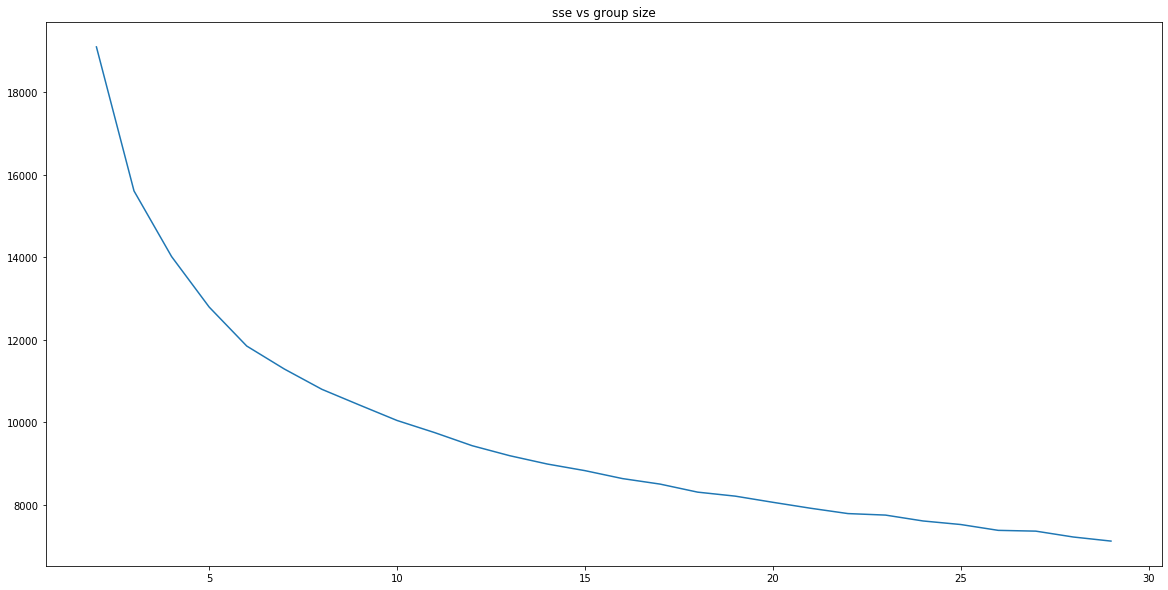

In [29]:
def sse_curve_data(data, cols, group_sizes=[i for i in range(2,30)]):
    sses = list()
    for g in group_sizes:
        res = KMeans(n_clusters=g, random_state=23).fit(data[cols])
        sses.append(res.inertia_)
    return sses

sse_res = sse_curve_data(standardized_numerical, standardized_numerical.columns, [i for i in range(2,30)])
plt.figure(figsize=(20,10))
plt.plot([i for i in range(2,30)], sse_res)
plt.title('sse vs group size')



### Elbow technique
Visually, it is hard to see the elbow in the above diagram; however, I would say that at 15 groups, we have passed the elbow, so we will take a look at 10 groups.

In [30]:
kmeans_10 = KMeans(n_clusters=10, random_state=23).fit(standardized_numerical)

In [31]:
combined_espn.columns

Index(['PNAME', 'YEAR', 'GP', 'GS', 'MIN', 'FG', 'FG%', '3PT', '3P%', 'FT',
       'FT%', 'OR', 'DR', 'REB', 'AST', 'BLK', 'STL', 'PF', 'TO', 'PTS',
       'FIRST_NAME', 'LAST_NAME', 'RK', 'NAME', 'TEAM', 'SALARY', 'SALARY_M',
       'POSN', 'SAL_M_ADJ', 'SAL_M_ADJ2'],
      dtype='object')

In [32]:
labels_10 = kmeans_10.labels_

#print(np.unique(labels_10))

# add labels to complete dataset and investigate each group (see if there are any differences with salary)
combined_espn['cluster'] = labels_10

# Investigate
# combined_espn[combined_espn.cluster == 1].head()

# cluster sizes
print('cluster sizes:', [combined_espn[combined_espn.cluster == i].shape[0] for i in range(10)])

# median salaries
print('cluster median salary ($ mil):', [combined_espn[combined_espn.cluster == i].SALARY_M.median() for i in range(10)])

# mode position
print('cluster mode position:', [combined_espn[combined_espn.cluster == i].POSN.mode()[0] for i in range(10)])

# could compare the differences between similar position groups

# 
print('cluster median mins:', [combined_espn[combined_espn.cluster == i].MIN.median() for i in range(10)])

cluster sizes: [88, 300, 120, 58, 356, 103, 278, 165, 146, 169]
cluster median salary ($ mil): [9.026, 1.639, 18.417, 1.275, 3.5534999999999997, 4.062, 3.838, 3.95, 1.9700000000000002, 7.0]
cluster mode position: ['C', 'SG', 'PF', 'SG', 'SG', 'C', 'SG', 'PF', 'C', 'PG']
cluster median mins: [33.0, 15.5, 34.0, 7.1, 24.7, 28.1, 31.7, 26.4, 16.9, 34.4]


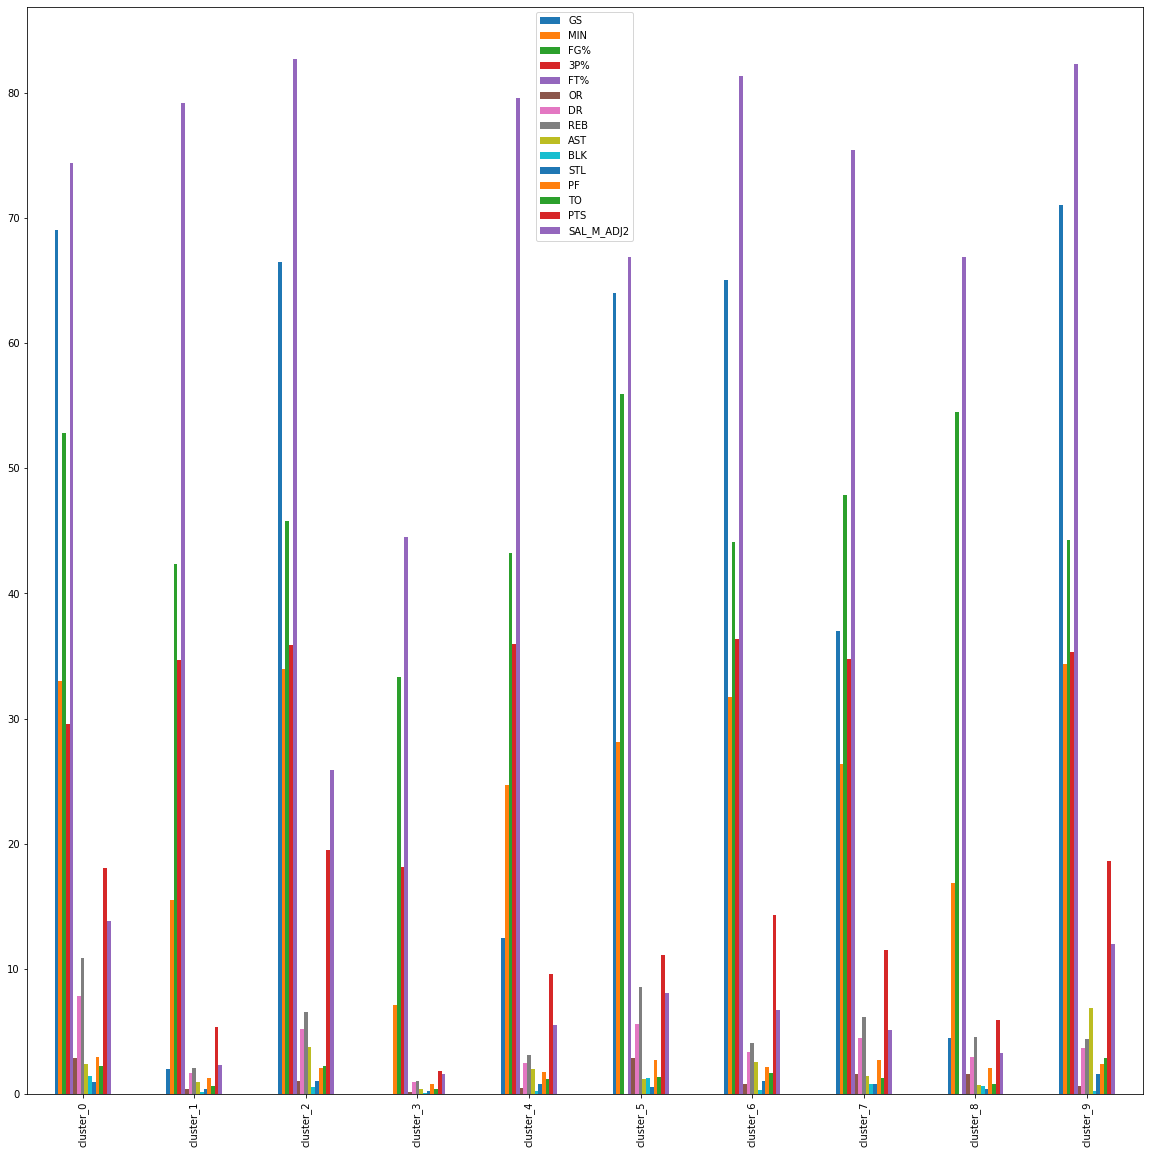

In [33]:
combined_espn[combined_espn.cluster == 0][num_cols].median(axis=0)

# create a dataframe
# row: stat
# column: cluster number

cluster_summary = pd.DataFrame({})

for i in range(10):
    cluster_summary['cluster_'+str(i)] = combined_espn[combined_espn.cluster == i][num_cols+['SAL_M_ADJ2']].median(axis=0)
    
cluster_summary.transpose().plot.bar(figsize=(20,20))


In [34]:
combined_espn[combined_espn.cluster == 5].PNAME.unique().size

36

In [35]:
cluster_summary.round(2)

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
GS,69.00,2.00,66.50,0.00,12.50,64.00,65.00,37.00,4.50,71.00
MIN,33.00,15.50,34.00,7.10,24.70,28.10,31.70,26.40,16.90,34.40
FG%,52.85,42.35,45.80,33.30,43.20,55.90,44.15,47.90,54.50,44.30
3P%,29.55,34.65,35.85,18.15,36.00,0.00,36.40,34.80,0.00,35.30
FT%,74.40,79.20,82.70,44.55,79.60,66.90,81.35,75.40,66.85,82.30
OR,2.90,0.40,1.10,0.20,0.50,2.90,0.80,1.60,1.60,0.70
DR,7.85,1.70,5.25,0.95,2.50,5.60,3.40,4.50,2.95,3.70
REB,10.90,2.10,6.60,1.05,3.10,8.60,4.10,6.20,4.60,4.40
AST,2.40,1.00,3.75,0.45,2.00,1.20,2.60,1.50,0.75,6.90
BLK,1.45,0.20,0.55,0.10,0.30,1.30,0.35,0.80,0.70,0.30


### Notes
- cluster 2 has the highest median adjusted salary
    - has the highest points scored
    - best free throw percentage
    - not the best 3-point percentage or field goal percentage
    - second highest assists
    - low blocks
    - average rebounds
    - not most games and not most games started

In [36]:
# let's look at the distributions of cluster 2
cluster_2 = combined_espn[combined_espn.cluster == 2]
cluster_2.PNAME.unique()

array(['damian-lillard', 'jimmy-butler', 'stephen-curry',
       'andre-iguodala', 'khris-middleton', 'rudy-gay', 'victor-oladipo',
       'chris-paul', 'bradley-beal', 'aaron-gordon', 'andrew-wiggins',
       'kevin-love', 'nicolas-batum', 'jayson-tatum', 'nikola-jokic',
       'kevin-durant', 'kyrie-irving', 'blake-griffin', 'brook-lopez',
       'marc-gasol', 'paul-george', 'mike-conley', 'kawhi-leonard',
       'danilo-gallinari', 'carmelo-anthony', 'harrison-barnes',
       'russell-westbrook', 'derrick-rose', 'al-horford', 'paul-millsap',
       'gordon-hayward', 'tobias-harris', 'thaddeus-young'], dtype=object)

In [37]:
cluster_2.columns

Index(['PNAME', 'YEAR', 'GP', 'GS', 'MIN', 'FG', 'FG%', '3PT', '3P%', 'FT',
       'FT%', 'OR', 'DR', 'REB', 'AST', 'BLK', 'STL', 'PF', 'TO', 'PTS',
       'FIRST_NAME', 'LAST_NAME', 'RK', 'NAME', 'TEAM', 'SALARY', 'SALARY_M',
       'POSN', 'SAL_M_ADJ', 'SAL_M_ADJ2', 'cluster'],
      dtype='object')

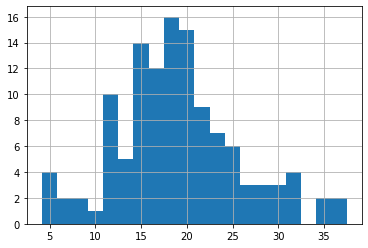

In [38]:
cluster_2.SALARY_M.hist(bins=20)

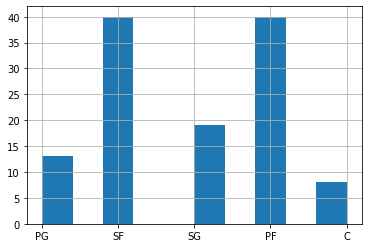

In [39]:
cluster_2.POSN.hist()

In [40]:
cluster_1 = combined_espn[combined_espn.cluster == 1]
cluster_4 = combined_espn[combined_espn.cluster == 4]
cluster_9 = combined_espn[combined_espn.cluster == 9]

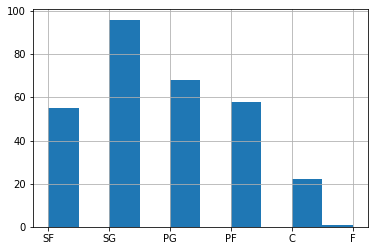

In [41]:
cluster_1.POSN.hist()

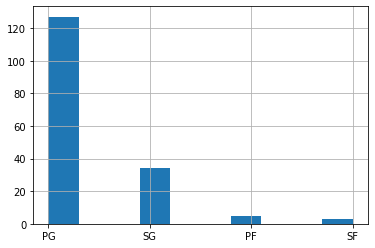

In [42]:
cluster_9.POSN.hist()

look at differences between the lowest 10% and highest 10% in cluster

In [43]:
sal_10p, sal_90p =  np.percentile(cluster_4.SALARY_M.values, [10,90])
print(sal_10p, sal_90p)

0.949 13.5


In [44]:
# compare stats for averages of each group
cluster_4[cluster_4.SALARY_M <= sal_10p].mean(axis=0)
cluster_4[cluster_4.SALARY_M >= sal_90p].mean(axis=0)
# column for relative differences

# create dataframe for comparison

YEAR          2018.216216
GP              37.675676
GS              11.918919
MIN             25.754054
FG%             41.478378
3P%             34.370270
FT%             80.816216
OR               0.589189
DR               2.594595
REB              3.181081
AST              2.959459
BLK              0.318919
STL              0.775676
PF               1.954054
TO               1.483784
PTS             11.005405
RK              54.945946
SALARY_M        17.199432
SAL_M_ADJ       17.812989
SAL_M_ADJ2      18.651742
cluster          4.000000
dtype: float64

In [45]:
combined_espn.YEAR.max()

2019

### Analyze/Cluster players based on position

In [46]:
# posn's ['PG', 'SF', 'SG', 'PF', 'C', 'F']
pgs = combined_espn[combined_espn.POSN=='PG']
sgs = combined_espn[combined_espn.POSN=='SG']
sfs = combined_espn[combined_espn.POSN=='PF']
pfs = combined_espn[combined_espn.POSN=='SF']
cs = combined_espn[combined_espn.POSN=='C']
fs = combined_espn[combined_espn.POSN=='F']

In [47]:
combined_espn.POSN.unique()

array(['PG', 'SF', 'SG', 'PF', 'C', 'F'], dtype=object)

In [48]:
pgs.describe()

,YEAR,GP,GS,MIN,FG%,3P%,FT%,OR,DR,REB,...,BLK,STL,PF,TO,PTS,RK,SALARY_M,SAL_M_ADJ,SAL_M_ADJ2,cluster
count,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,...,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000
mean,2015.578534,56.921466,37.028796,26.804188,43.450000,34.114921,78.735079,0.630366,2.710209,3.337435,...,0.252094,1.081414,1.956545,1.965183,12.897382,204.759162,7.082018,7.540727,9.551271,5.369110
std,3.019249,21.689145,30.191110,7.682921,4.012499,6.497051,11.853995,0.357697,1.261701,1.523632,...,0.176978,0.523460,0.620809,0.962863,6.210375,141.660826,7.313895,7.636698,9.030217,2.992973
min,2006.000000,3.000000,0.000000,5.200000,23.400000,0.000000,0.000000,0.000000,0.300000,0.700000,...,0.000000,0.100000,0.200000,0.200000,1.200000,1.000000,0.016000,0.017029,0.018756,0.000000
25%,2014.000000,43.000000,5.000000,21.425000,41.400000,31.525000,75.050000,0.400000,1.800000,2.200000,...,0.100000,0.700000,1.500000,1.200000,8.125000,83.000000,1.634000,1.748997,2.497985,4.000000
50%,2016.000000,62.500000,36.000000,28.650000,43.550000,35.250000,80.600000,0.600000,2.600000,3.200000,...,0.200000,1.000000,2.000000,1.900000,11.950000,194.000000,3.748500,4.161636,6.026833,5.000000
75%,2018.000000,75.750000,67.000000,33.000000,46.000000,37.775000,85.700000,0.800000,3.500000,4.200000,...,0.300000,1.400000,2.400000,2.600000,17.175000,302.750000,11.278250,11.847993,14.232052,9.000000
max,2019.000000,82.000000,82.000000,38.500000,58.000000,51.900000,100.000000,2.200000,9.600000,11.100000,...,1.100000,2.800000,3.600000,5.400000,31.600000,655.000000,37.457000,39.046375,41.833349,9.000000


## Questions:
1. What are the commonalities amongst the players that score the most points?
2. What are the commonalities amongst players with the higher player efficiency?
3. Which statistics are most important when it comes to player stats?
    1. What are the principal components?

### PCA
Look into the principal components of the data

In [49]:
# from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
import pprint

In [50]:
n_components = 8
pca = PCA(n_components = n_components)

a = pca.fit_transform(standardized_numerical)

print(pca.explained_variance_ratio_)
print('sum:',np.sum(pca.explained_variance_ratio_))

[0.42417031 0.2189328  0.06948875 0.05267666 0.04280127 0.03883923
 0.03110294 0.02967003]
sum: 0.9076820059505786


In [51]:
standardized_numerical.columns

Index(['GS_SD', 'MIN_SD', 'FG%_SD', '3P%_SD', 'FT%_SD', 'OR_SD', 'DR_SD',
       'REB_SD', 'AST_SD', 'BLK_SD', 'STL_SD', 'PF_SD', 'TO_SD', 'PTS_SD',
       'SAL_M_ADJ2_SD'],
      dtype='object')

Notes:
- explaining more than 90% of the variation in the data

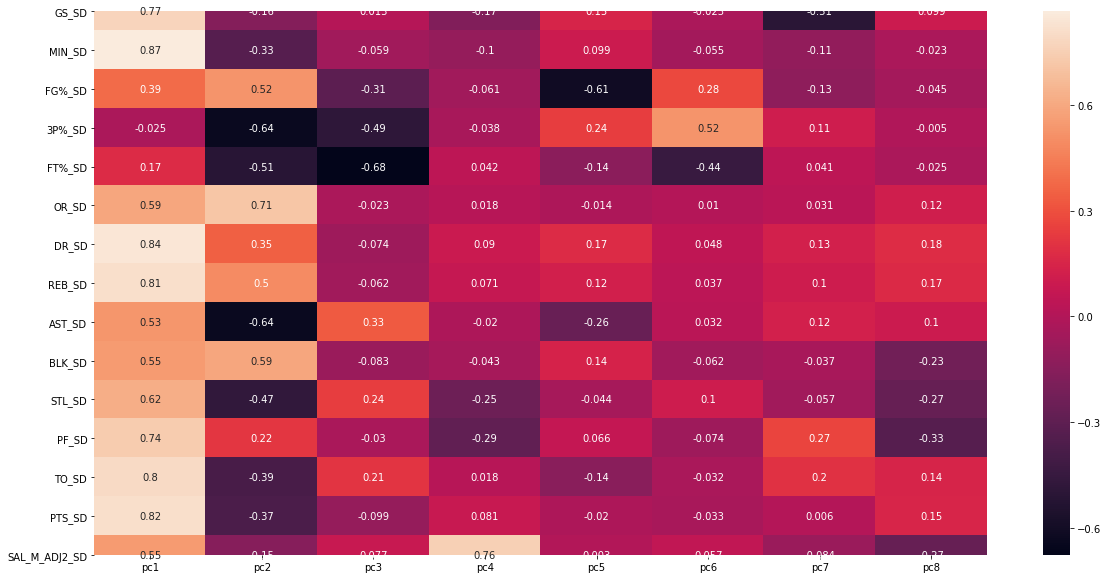

In [52]:
import seaborn as sns

a = pca.components_.T * np.sqrt(pca.explained_variance_)
np.sum(np.round(a,3), axis=1)
np.round(a,3)

loadings = pd.DataFrame(a).round(3)
loadings.index = standardized_numerical.columns
loadings.columns = ['pc'+str(i+1) for i in range(n_components)]
# loadings

fig, ax = plt.subplots(figsize=(20,10))

sns.heatmap(ax=ax,data=loadings, annot=True)


Notes:
- pc1
    - lots of highly positively correlated variables > 0.7:
        - games started
        - minutes
        - deffensive rebounds
        - rebounds
        - personal fouls
        - turnovers 
        - points
    - this best describes the factors that distinguish the key players
        - great players play a lot, score a lot, and get turnovers/fouls
    - also worth noting that Salary has a 0.5 correlation
- pc2
    - correlated variables >0.5:
        - offensive rebounds
        - rebounds
        - blocks
        - field goal percentage
    - negatively correlated variables <-0.5:
        - 3PT percentage
        - FT%
        - Assists
- pc3
    - Salary has a high correlation >0.81
        

In [53]:
np.round(pca.components_.T,3)

array([[ 0.306, -0.088,  0.012, -0.195,  0.182, -0.03 , -0.743,  0.148],
       [ 0.343, -0.182, -0.058, -0.118,  0.123, -0.072, -0.167, -0.034],
       [ 0.154,  0.289, -0.301, -0.068, -0.762,  0.365, -0.185, -0.068],
       [-0.01 , -0.35 , -0.478, -0.043,  0.3  ,  0.686,  0.157, -0.008],
       [ 0.069, -0.282, -0.663,  0.048, -0.171, -0.582,  0.061, -0.037],
       [ 0.235,  0.392, -0.023,  0.021, -0.018,  0.014,  0.045,  0.172],
       [ 0.334,  0.194, -0.073,  0.101,  0.219,  0.063,  0.186,  0.268],
       [ 0.322,  0.275, -0.06 ,  0.08 ,  0.152,  0.049,  0.15 ,  0.253],
       [ 0.212, -0.35 ,  0.324, -0.022, -0.327,  0.042,  0.182,  0.151],
       [ 0.218,  0.325, -0.081, -0.048,  0.175, -0.081, -0.054, -0.337],
       [ 0.247, -0.261,  0.24 , -0.279, -0.055,  0.132, -0.083, -0.406],
       [ 0.292,  0.122, -0.029, -0.327,  0.082, -0.097,  0.393, -0.495],
       [ 0.315, -0.213,  0.209,  0.02 , -0.178, -0.041,  0.292,  0.217],
       [ 0.324, -0.206, -0.097,  0.091, -0.025, -0.



### Further investigation
- Further investigation could be done into the ranks (have each cell be the row rank for the stat, e.g. each row has numbers 0 to 9). Alternatively, we could normalize all the rows and plot the heatmap

### Heatmap visualization

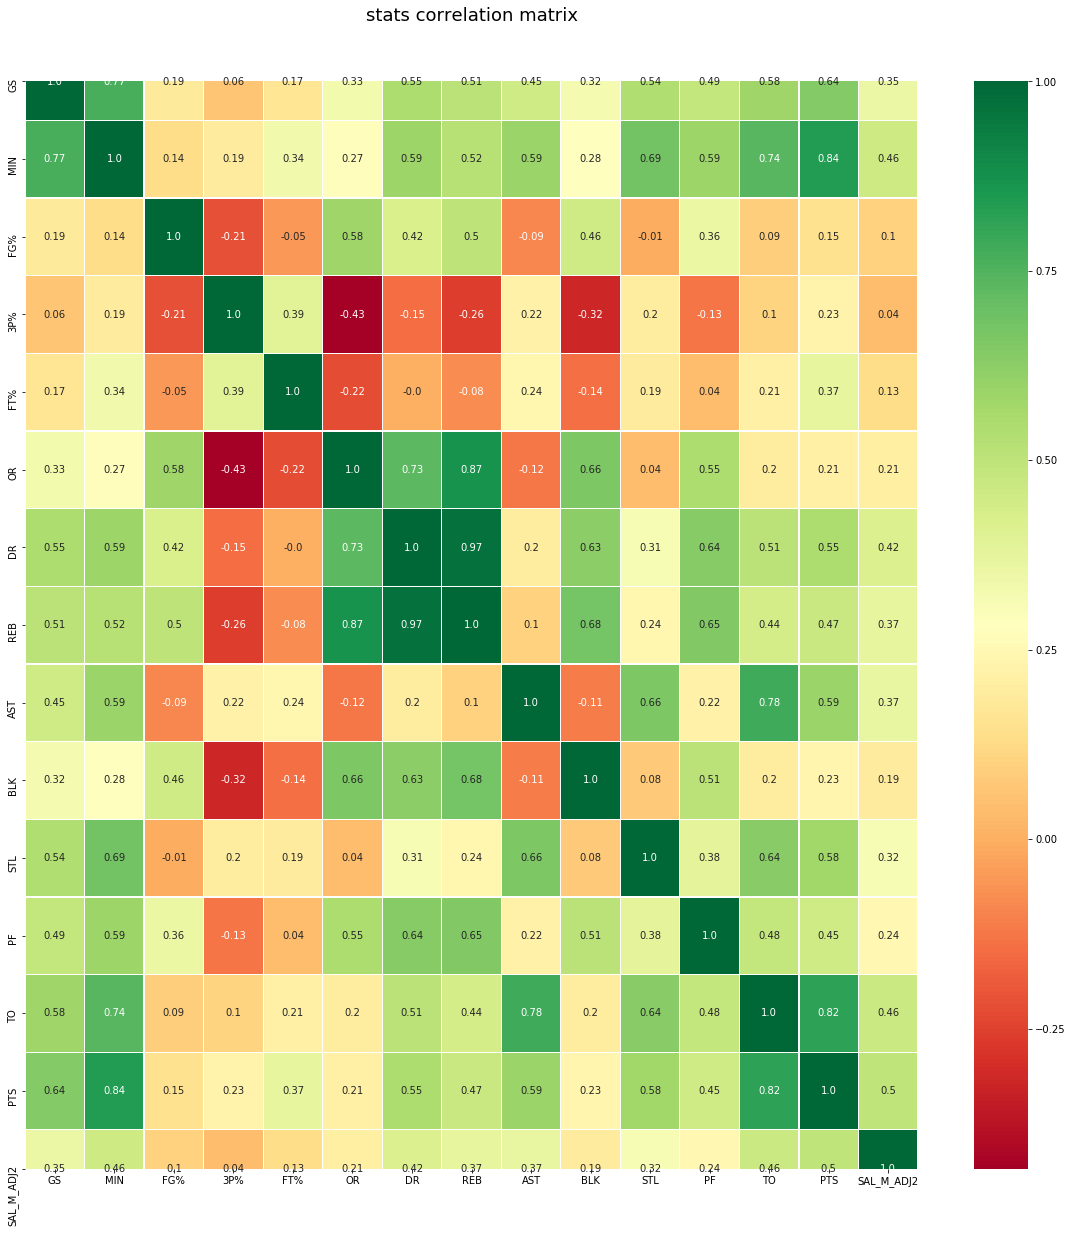

In [54]:
import seaborn as sns

corr_mat = combined_espn[norm_cols].corr()


fig, ax = plt.subplots(figsize=(20,20))
plt.title('stats correlation matrix', fontsize=18)
ttl = ax.title
ttl.set_position([0.5,1.05])

sns.heatmap(corr_mat, annot=corr_mat.round(2).values, fmt="", cmap="RdYlGn", linewidths=0.30, ax=ax)

plt.show()


### Notes:
- Salary is highest correlated with minutes, rebounds, turnovers (?), and points
- why is Salary correlated with turnovers?
    - turnovers and points are highly correlated

* [Go back to table of contents](#main)

---

---

<a class='anchor' id='section_3_3'></a>

## 3.3 Home Advantage Analysis

### Objective : 

NBA has the highest home-court win percentage of the four major American sports leagues, with a historical overall winning percentage of 60%. 

We want to investigate the reason behind this statistic. 

#### Why analyze stats for the Regular Season and not Post Season/Playoffs?

During the regular season, teams have very little preparation time for a game. They generally arrive at the home teams stadium the night before. So, the effects of scouting and advanced tactics are much less expressed during the regular season. Moreover, teams in the NBA are notorious for not playing their best players/ optimal intensity during the playoffs. So, teams are a bit more balanced and elite teams have a greater chance of losing. This implies that if any such thing as home advantage exists, it will be much more pronounced during the regular season. 


In [1]:
# imports
import pandas as pd
import sklearn
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
from scipy import stats
from statsmodels.stats import weightstats as stests
from scipy.stats import ttest_ind
from sklearn.manifold import TSNE
from matplotlib import rcParams
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA 
import pprint

We will be using 3 dataframes for our home advantage analysis:

### 1. master_df 

#### GLOSSARY
contains the following features separated by home and away for all seasons from 2002-2020.

GP:Games Played | GS:Games Started | MIN:Minutes Per Game | PTS:Points Per Game | OR:Offensive Rebounds Per Game

DR:Defensive Rebounds Per Game | REB:Rebounds Per Game | AST:Assists Per Game | STL:Steals Per Game 

BLK:Blocks Per Game | TO:Turnovers Per Game | PF:Fouls Per Game | AST/TO:Assist To Turnover Ratio


### 2. shots_df 

#### GLOSSARY
contains the following features separated by home and away for all seasons from 2002-2020.

FGM:Average Field Goals Made | FGA:Average Field Goals Attempted | FG%:Field Goal Percentage

3PM:Average 3-Point Field Goals Made | 3PA:Average 3-Point Field Goals Attempted | 3P%:3-Point Field Goal Percentage

FTM:Average Free Throws Made | FTA:Average Free Throws Attempted | FT%:Free Throw Percentage 

2PM:2-Point Field Goals Made / game | 2PA:2-Point Field Goals Attempted per Game | 2P%:2-Point Field Goal Percentage

SC-EFF:Scoring Efficiency | SH-EFF:Shooting Efficiency

### 3.ref_df

#### GLOSSARY
contains the following statistics of referees from 2009-2020

YEAR:year of officiating | TYPE:Crew Referee/Main Referee | GAMES OFFICIATED: No. of games officiated in that year

HTW%:Home team win % under that referee | HTPD:Home team points differential | TPPG:Average total points per game

CFPG:Called fouls per game | FAR%:Foul % agaist away teams | FAH%:Foul percentage against home teams

### Load the Datasets

In [2]:
# type = 33 refers to home games, 34 refers to away games
master_df = pd.read_csv('home_away.csv')
master_df.head()

,PNAME,POS,TEAM,YEAR,TYPE,GP,GS,MIN,PTS,OR,DR,REB,AST,STL,BLK,TO,PF,AST/TO,PER
0,Jamal Mashburn,SF,no,2003,33,41,40,40.4,22.4,0.7,5.6,6.3,5.7,1.0,0.3,2.9,2.3,2.0,0
1,David Wesley,SG,no,2003,33,36,36,38.1,17.6,0.7,1.8,2.5,4.0,1.6,0.2,1.8,2.5,2.2,0
2,Baron Davis,PG,no,2003,33,25,25,37.0,16.9,1.0,2.7,3.7,7.4,2.0,0.6,2.8,3.0,2.7,0
3,Jamaal Magloire,C,no,2003,33,41,41,31.5,11.5,3.7,6.3,10.0,1.5,0.7,1.6,1.9,3.2,0.8,0
4,P.J. Brown,PF,no,2003,33,39,39,32.9,11.3,2.7,5.7,8.4,1.9,0.9,1.0,1.3,2.6,1.4,0


In [3]:
# type = 33 refers to home games, 34 refers to away games
shots_df = pd.read_csv('shots_home_away_stats.csv')
shots_df.head()

,PNAME,POS,TEAM,YEAR,TYPE,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,2PM,2PA,2P%,SC-EFF,SH-EFF
0,Shareef Abdur-Rahim,PF,atl,2002,33,8.1,17.1,47.4,0.4,1.1,39.0,5.2,6.4,81.6,7.7,16.0,48.0,1.279,0.49
1,Jason Terry,G,atl,2002,33,7.3,16.3,44.6,2.3,5.7,39.9,3.9,4.7,82.0,5.0,10.6,47.1,1.269,0.52
2,Theo Ratliff,C,atl,2002,33,5.0,8.0,62.5,0.0,0.0,0.0,2.0,6.0,33.3,5.0,8.0,62.5,1.500,0.63
3,Toni Kukoc,SF,atl,2002,33,4.1,9.1,45.3,1.1,3.0,36.7,2.0,2.7,76.3,3.0,6.1,49.5,1.248,0.51
4,Dion Glover,SG,atl,2002,33,4.5,9.8,46.3,0.8,2.3,36.8,1.3,1.6,78.0,3.7,7.5,49.2,1.143,0.51


In [4]:
ref_df = pd.read_csv('referee_stats.csv')
ref_df.head()

,YEAR,TYPE,GAMES OFFICIATED,HTW%,HTPD,TPPG,CFPG,FAR%,FAH%
0,2020,CREW,54,0.574,3.704,217.370,39.333,50.189,49.812
1,2020,CREW,55,0.618,2.745,221.618,42.545,50.855,49.146
2,2020,CREW,55,0.564,2.036,224.582,43.273,50.126,49.874
3,2020,CREW,56,0.464,0.571,226.393,40.768,51.905,48.094
4,2020,CREW,54,0.500,-0.278,229.870,44.185,50.797,49.204


### Clean the Datasets

In [5]:
master_df.describe()

,YEAR,TYPE,GP,GS,MIN,PTS,OR,DR,REB,AST,STL,BLK,TO,PF,AST/TO,PER
count,19289.000000,19289.000000,19289.000000,19289.000000,19289.000000,19289.00000,19289.000000,19289.000000,19289.000000,19289.000000,19289.000000,19289.000000,19289.000000,19289.000000,19289.0,19289.0
mean,2011.495982,33.499093,23.632174,11.450308,20.059443,8.08045,0.918715,2.592742,3.508761,1.786002,0.629307,0.402167,1.151874,1.801659,inf,0.0
std,5.472670,0.500012,13.132732,13.993289,10.014791,5.97299,0.835390,1.821683,2.502688,1.786815,0.464474,0.481532,0.813595,0.849869,NaN,0.0
min,2002.000000,33.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25%,2007.000000,33.000000,12.000000,0.000000,11.900000,3.50000,0.300000,1.300000,1.700000,0.600000,0.300000,0.100000,0.600000,1.200000,0.8,0.0
50%,2012.000000,33.000000,26.000000,4.000000,19.600000,6.70000,0.700000,2.200000,3.000000,1.200000,0.500000,0.300000,1.000000,1.800000,1.3,0.0
75%,2016.000000,34.000000,36.000000,21.000000,28.300000,11.40000,1.300000,3.400000,4.700000,2.400000,0.900000,0.500000,1.600000,2.400000,2.0,0.0
max,2020.000000,34.000000,41.000000,41.000000,48.000000,37.90000,7.000000,12.100000,18.000000,12.700000,3.200000,6.000000,6.300000,6.000000,inf,0.0


Observations : 
1. PER has all 0 values.
2. None of the columns have missing values. 
3. AST/TO has INF mean and NAN std, such values should be removed. 
4. There are observations where the player has played 0 minutes in a season, we should remove that.

So, we clean the data in the following code block

In [6]:
master_df = master_df.drop(columns=['PER']) # drop the PER column
# master_df[master_df['MIN']==0.0] # 16 players have played 0 minutes 
master_df = master_df[master_df['MIN'] != 0.0] # remove the players who havent played any minutes
master_df = master_df[master_df['AST/TO'] != np.inf] # remove the observations where AST/TO is INF
master_df.describe()

,YEAR,TYPE,GP,GS,MIN,PTS,OR,DR,REB,AST,STL,BLK,TO,PF,AST/TO
count,18847.000000,18847.000000,18847.000000,18847.000000,18847.000000,18847.000000,18847.000000,18847.000000,18847.000000,18847.000000,18847.000000,18847.000000,18847.000000,18847.000000,18847.000000
mean,2011.466334,33.499071,24.104950,11.717515,20.355054,8.219855,0.932881,2.634377,3.564509,1.809333,0.638399,0.408712,1.178835,1.827028,1.475476
std,5.469482,0.500012,12.905987,14.045854,9.903014,5.958998,0.835049,1.816654,2.496676,1.797503,0.462270,0.483157,0.803546,0.834915,1.078696
min,2002.000000,33.000000,1.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2007.000000,33.000000,12.000000,0.000000,12.300000,3.700000,0.300000,1.300000,1.800000,0.600000,0.300000,0.100000,0.600000,1.300000,0.800000
50%,2012.000000,33.000000,26.000000,4.000000,20.000000,6.800000,0.700000,2.300000,3.000000,1.200000,0.600000,0.300000,1.000000,1.800000,1.300000
75%,2016.000000,34.000000,36.000000,22.000000,28.500000,11.600000,1.300000,3.500000,4.700000,2.400000,0.900000,0.500000,1.600000,2.400000,2.000000
max,2020.000000,34.000000,41.000000,41.000000,48.000000,37.900000,7.000000,12.100000,18.000000,12.700000,3.200000,6.000000,6.300000,5.500000,20.000000


In [7]:
shots_df.describe()

,YEAR,TYPE,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,2PM,2PA,2P%,SC-EFF,SH-EFF
count,19307.000000,19307.000000,19307.000000,19307.000000,19307.000000,19307.000000,19307.000000,19307.000000,19307.000000,19307.000000,19307.000000,19307.000000,19307.000000,19307.000000,19307.000000,19307.000000
mean,2011.503910,33.499560,3.018335,6.761004,42.964930,0.606189,1.738768,23.769141,1.443155,1.923820,67.302755,2.413467,5.024525,45.805247,1.146687,0.470631
std,5.476272,0.500013,2.180458,4.607926,12.575957,0.713546,1.851453,19.408221,1.415204,1.773382,25.144918,1.909204,3.765015,14.145289,0.330984,0.133706
min,2002.000000,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2007.000000,33.000000,1.300000,3.200000,38.900000,0.000000,0.100000,0.000000,0.500000,0.700000,60.700000,1.000000,2.200000,41.700000,1.032500,0.430000
50%,2012.000000,33.000000,2.500000,5.700000,43.800000,0.300000,1.200000,29.200000,1.000000,1.400000,74.600000,1.900000,4.000000,47.200000,1.169000,0.490000
75%,2016.000000,34.000000,4.300000,9.500000,48.900000,1.000000,2.900000,37.400000,2.000000,2.600000,82.600000,3.400000,7.000000,52.100000,1.299000,0.530000
max,2020.000000,34.000000,12.800000,28.400000,100.000000,5.300000,13.300000,100.000000,12.600000,14.200000,100.000000,11.300000,23.700000,100.000000,7.000000,1.500000


Observations : 
1. No missing values or Nan values in any column. 
2. However, 220 observations have 0 field goals attempted. We will remove them as they are probably players who haven't played 
   a single minute or played just a few minutes in the entire season.

In [8]:
shots_df = shots_df[shots_df['FGA'] != 0]
shots_df.describe()

,YEAR,TYPE,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,2PM,2PA,2P%,SC-EFF,SH-EFF
count,19087.000000,19087.000000,19087.000000,19087.000000,19087.000000,19087.000000,19087.000000,19087.000000,19087.000000,19087.000000,19087.000000,19087.000000,19087.000000,19087.000000,19087.000000,19087.000000
mean,2011.502384,33.500079,3.053125,6.838932,43.460151,0.613177,1.758810,24.043108,1.458836,1.944177,68.015188,2.441285,5.082438,46.333206,1.159904,0.476056
std,5.478458,0.500013,2.168635,4.576544,11.766657,0.714655,1.852604,19.350286,1.415338,1.772449,24.302742,1.902409,3.747583,13.339125,0.309002,0.124503
min,2002.000000,33.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2007.000000,33.000000,1.400000,3.300000,39.100000,0.000000,0.100000,0.000000,0.500000,0.700000,61.500000,1.000000,2.300000,41.900000,1.039000,0.440000
50%,2012.000000,34.000000,2.600000,5.800000,43.900000,0.400000,1.200000,29.500000,1.000000,1.400000,75.000000,1.900000,4.100000,47.400000,1.171000,0.490000
75%,2016.000000,34.000000,4.300000,9.500000,49.000000,1.000000,2.900000,37.500000,2.000000,2.600000,82.700000,3.400000,7.100000,52.200000,1.300000,0.530000
max,2020.000000,34.000000,12.800000,28.400000,100.000000,5.300000,13.300000,100.000000,12.600000,14.200000,100.000000,11.300000,23.700000,100.000000,7.000000,1.500000


Now we check if both the datasets are balanced.

In [9]:
# type = 33 refers to home games, 34 refers to away games
print(master_df['TYPE'].value_counts())
print(shots_df['TYPE'].value_counts())

33    9441
34    9406
Name: TYPE, dtype: int64
34    9545
33    9542
Name: TYPE, dtype: int64


Both datasets are pretty balanced as they have almost equal number of observations for home and away games.

Finally, we spilt both the datasets into home and away datasets. 
So, master_df becomes (master_home), (master_away)
And, shots_df becomes (shots_home), (shots_away)

In [10]:
master_home = master_df[master_df['TYPE'] == 33]
master_away = master_df[master_df['TYPE'] == 34]

shots_home = shots_df[shots_df['TYPE'] == 33]
shots_away = shots_df[shots_df['TYPE'] == 34]

Check if the referee dataset needs preprocessing 

In [11]:
ref_df.describe()

,YEAR,GAMES OFFICIATED,HTW%,HTPD,TPPG,CFPG,FAR%,FAH%
count,1272.000000,1272.000000,1272.000000,1272.000000,1272.000000,1272.000000,1272.000000,1272.000000
mean,2015.483491,35.298742,0.588562,2.909266,207.926937,40.825454,50.737887,49.260451
std,3.575603,22.739528,0.178662,4.811666,13.169819,2.665919,2.300288,2.299913
min,2009.000000,1.000000,0.000000,-24.000000,161.000000,23.000000,36.400000,35.000000
25%,2013.000000,12.000000,0.520000,1.100000,198.975000,39.500000,50.000000,48.400000
50%,2016.000000,39.000000,0.587000,2.800000,205.400000,40.800000,50.800000,49.200000
75%,2019.000000,56.000000,0.652000,4.500000,218.812500,42.200000,51.600000,50.000000
max,2020.000000,73.000000,1.000000,32.000000,282.000000,54.000000,65.000000,63.600000


#### Using t-SNE to visualize the data

In [12]:
master_features = master_df.drop(columns=['PNAME', 'POS', 'TEAM', 'TYPE'])

In [13]:
embedded_master_features = TSNE(n_components=2).fit_transform(master_features)
master_tsne = pd.DataFrame(embedded_master_features, columns=['comp1', 'comp2'])

In [14]:
master_tsne['TYPE'] = master_df['TYPE']

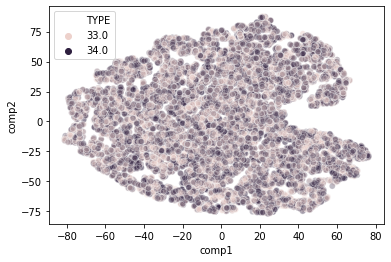

In [15]:
sns.scatterplot(
    x="comp1", y="comp2",
    hue="TYPE",
    data=master_tsne,
    legend="full",
    alpha=0.3,
)

TYPE = 33 refers to home games, 34 refers to away games

The data looks indistinguishable when plotted against the first 2 components. We will analyse each statistic now to check for significant difference.


Referee dataset doesn't need any preprocessing, so we can procees with data analysis

# Visualize the data for analysis and check significance

In [16]:
def perform_z_test(home_df, away_df):
    ztest ,pval = stests.ztest(home_df, x2=away_df, value=0,alternative='two-sided')
    print('Z statistic : ', float(ztest))
    print('p value : ', float(pval))
    if pval<0.05:
        print("Reject null hypothesis, i.e., there is significant difference between the 2 samples.")
    else:
        print("Accept null hypothesis, i.e., there is no significant difference between the 2 samples.")

In [17]:
# funnction to plot home and away stats by year
def plt_home_away_features_by_year(home_df, away_df, feature):
    home_df = home_df.groupby('YEAR')
    away_df = away_df.groupby('YEAR')
    home_store = []
    away_store = []
    
    for year, group in home_df:
        home_store.append(group[feature].mean())
    for year, group in away_df:
        away_store.append(group[feature].mean())
    X = np.arange(2002, 2021)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,0.8])
    ax.bar(X + 0.00, home_store, color = 'b', width = 0.25)
    ax.bar(X + 0.25, away_store, color = 'r', width = 0.25) 
    plt.xlabel('YEAR')
    plt.ylabel(feature)
    plt.legend(['Home', 'Away'],loc=2)

# GAMEPLAY STATS ANALYSIS

### AST/TO ANALYSIS

AST : An “assist” goes to the player who passes the ball to a teammate who then scores a basket.

TO  : A “turnover” is when a player loses possession of the ball to the opposite team. 
       Examples of turnovers include: stepping out of bounds, passing the ball out of bounds, creating an offensive foul,\
       being called for a violation, or having the ball stolen.
       
AST/TO : Assist to turnover ratio puts a player’s assists in context with their turnovers. It is often considered as 
measure of ball control/game dominance.

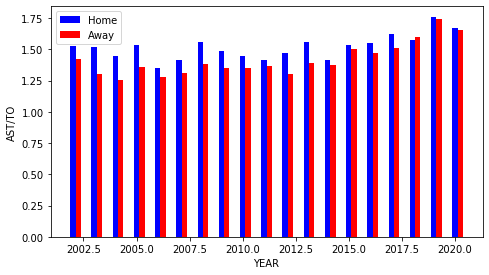

In [18]:
# plot the average AST/TO of players for home and away games
plt_home_away_features_by_year(master_home, master_away, 'AST/TO')

In [19]:
perform_z_test(master_home['AST/TO'], master_away['AST/TO'])

Z statistic :  6.225903072031957
p value :  4.787900181286169e-10
Reject null hypothesis, i.e., there is significant difference between the 2 samples.


Observation:

Every year with the exception of 2018 has higher average AST/TO per player in home games than away games.

Possible Reasons : 
1. Home team players have significantly better assist stats.
2. Away team give the ball away more and have greater turnovers.


### AVERAGE STEALS BY A PLAYER ANALYSIS

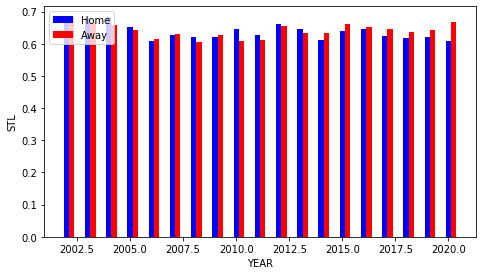

In [20]:
# plot the average steals by a player for home and away games
plt_home_away_features_by_year(master_home, master_away, 'STL')

In [21]:
perform_z_test(master_home['STL'], master_away['STL'])

Z statistic :  -0.5994633152580221
p value :  0.5488639661965138
Accept null hypothesis, i.e., there is no significant difference between the 2 samples.


### AVERAGE FOULS BY A PLAYER ANALYSIS

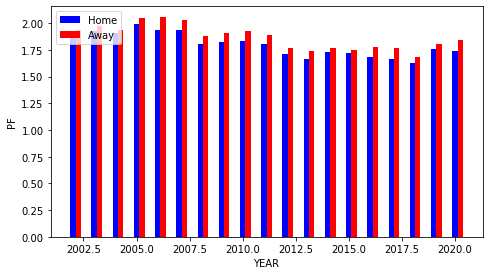

In [22]:
# plot the average fouls conceded by a player for home and away games
plt_home_away_features_by_year(master_home, master_away, 'PF')

In [23]:
perform_z_test(master_home['PF'], master_away['PF'])

Z statistic :  -5.643616891124309
p value :  1.6651438162018542e-08
Reject null hypothesis, i.e., there is significant difference between the 2 samples.


Observation : 
    
Every single season, on average the away team player concedes more fouls per game than home team players. This could have 2 possible inferences:
1. The away players are nervous/get frustrated leading to more fouls committed.
2. The referees decision is biased and the home team generally gets the favour of a decision. (We will look into this later).

### TUNROVERS BY A PLAYER ANALYSIS

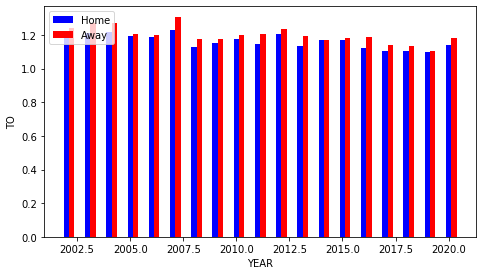

In [24]:
# As mentioned earlier, TO (Turnover) refers to the number of times the player gave away possession of the ball.
# plot the average turnover per player in home/away games.
plt_home_away_features_by_year(master_home, master_away, 'TO')

Observation :

In every year apart from 2014(same), the away team players gave away the ball more on average than home team players. 

In [25]:
perform_z_test(master_home['TO'], master_away['TO'])

Z statistic :  -2.9971631422636307
p value :  0.0027250483797951978
Reject null hypothesis, i.e., there is significant difference between the 2 samples.


Possible Reasons:

1. The home team players are significantly better at stealing the ball. (Disproven previously)
2. The away team players committed more fouls / mistakes and gave away the ball. (Proven to be significant previously)

### OFFENSIVE REBOUNDS ANALYSIS

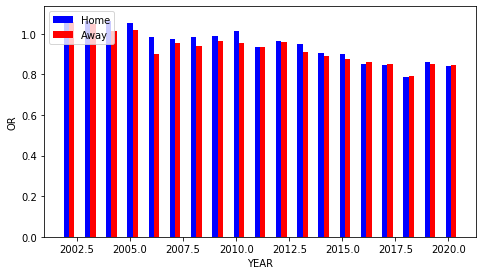

In [26]:
# Offensive rebounds awarded to a player analysis
plt_home_away_features_by_year(master_home, master_away, 'OR')

In [27]:
perform_z_test(master_home['OR'], master_away['OR'])

Z statistic :  1.643050211119988
p value :  0.10037254496864959
Accept null hypothesis, i.e., there is no significant difference between the 2 samples.


### DEFENSIVE REBOUNDS ANALYSIS

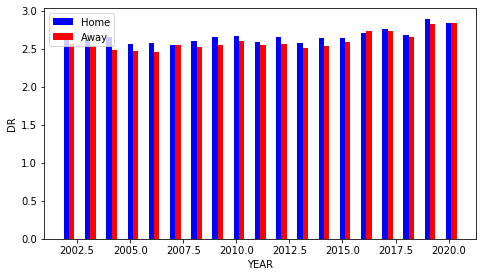

In [28]:
# Defensive rebounds awarded to a player analysis
plt_home_away_features_by_year(master_home, master_away, 'DR')

In [29]:
perform_z_test(master_home['DR'], master_away['DR'])

Z statistic :  2.4337663677626167
p value :  0.01494263645855765
Reject null hypothesis, i.e., there is significant difference between the 2 samples.


Observations : 
    
Home teams have significantly more defensive rebounds than away teams. 

Possible Reason:
Away teams are worse in shooting efficiency than home teams.(We will analyze this next).

# SHOOTING STATS ANALYSIS

### GENERAL SHOOTING EFFICIENCY ANALYSIS

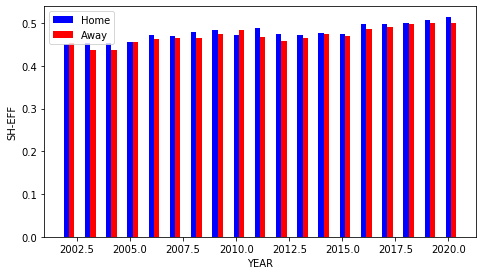

In [30]:
# plot the average shooting efficiency for players for home and away games
plt_home_away_features_by_year(shots_home, shots_away, 'SH-EFF')

Observation : 

In every year apart from 2002(away more), 2010(away more) and 2005(equal) the home team players had higher shooting efficiency than away team players on average. This could mean that away players were nervous/intimidated.

In [31]:
perform_z_test(shots_home['SH-EFF'], shots_away['SH-EFF'])

Z statistic :  4.418698338729855
p value :  9.929712941203198e-06
Reject null hypothesis, i.e., there is significant difference between the 2 samples.


So there is a significant difference between the shooting efficiencies of home and away teams.
Now this can be due to 3 factors :
    
    1. Shooting efficiency of 2 Pointers
    
    2. Shooting efficiency of 3 Pointers
    
    3. Shooting efficiency of free throws
    
So we will now have a look at each.

### 2 POINTERS ANALYSIS

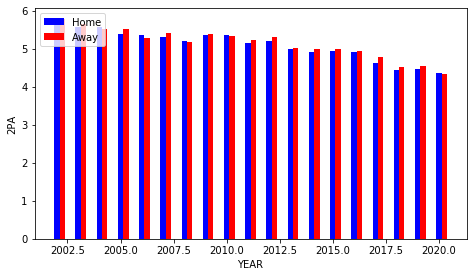

In [32]:
# plt the average number of 2 pointers attempted per game
plt_home_away_features_by_year(shots_home, shots_away, '2PA')

In [33]:
perform_z_test(shots_home['2PA'], shots_away['2PA'])

Z statistic :  -0.8526307483651704
p value :  0.39386410544680517
Accept null hypothesis, i.e., there is no significant difference between the 2 samples.


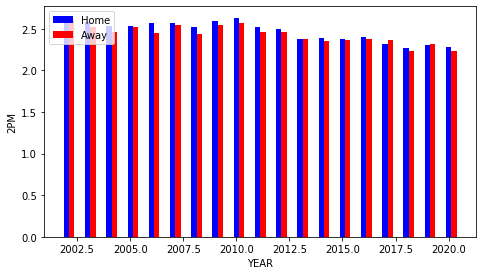

In [34]:
# plt the average number of 2 pointers successfully made per game
plt_home_away_features_by_year(shots_home, shots_away, '2PM')

In [35]:
perform_z_test(shots_home['2PM'], shots_away['2PM'])

Z statistic :  1.3953308957893766
p value :  0.16291607941058028
Accept null hypothesis, i.e., there is no significant difference between the 2 samples.


### 3 POINTERS ANALYSIS

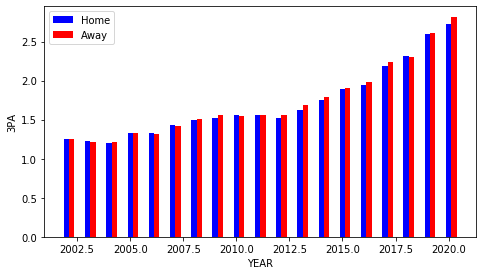

In [36]:
# plt the average number of 3 pointers attempted per game
plt_home_away_features_by_year(shots_home, shots_away, '3PA')

In [37]:
perform_z_test(shots_home['3PA'], shots_away['3PA'])

Z statistic :  -0.8209555218335292
p value :  0.4116716036714274
Accept null hypothesis, i.e., there is no significant difference between the 2 samples.


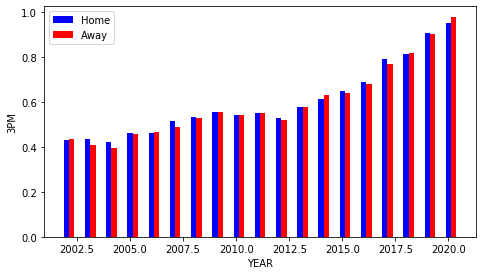

In [38]:
# plt the average number of 3 pointers successfully made per game
plt_home_away_features_by_year(shots_home, shots_away, '3PM')

In [39]:
perform_z_test(shots_home['3PM'], shots_away['3PM'])

Z statistic :  0.2485364417261448
p value :  0.8037193779594516
Accept null hypothesis, i.e., there is no significant difference between the 2 samples.


### FREE THROWS ANALYSIS

Free throws are given to a team when the opponent commits a foul. We have previously seen that Away team players commit significantly more number of fouls.
So, they get more number of free throws.


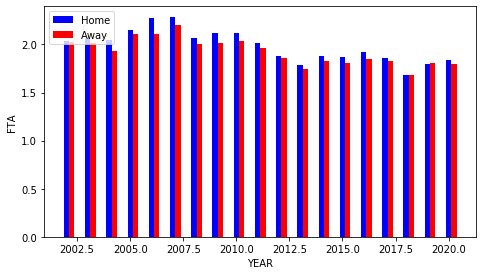

In [40]:
# plt the average number of free throws attempted per game
plt_home_away_features_by_year(shots_home, shots_away, 'FTA')

Observation: 

In every year with the exception of 2019, home teams have attempted more free throws on average than away teams. 

In [41]:
perform_z_test(shots_home['FTA'], shots_away['FTA'])

Z statistic :  2.142252588228268
p value :  0.0321731618059978
Reject null hypothesis, i.e., there is significant difference between the 2 samples.


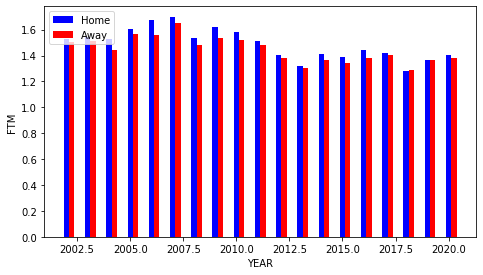

In [42]:
# plt the average number of free throws successfully made per game
plt_home_away_features_by_year(shots_home, shots_away, 'FTM')

In [43]:
perform_z_test(shots_home['FTM'], shots_away['FTM'])

Z statistic :  1.990450129038556
p value :  0.046541372476880116
Reject null hypothesis, i.e., there is significant difference between the 2 samples.


### CONCLUSION FROM SHOOTING STATS

Observation:
    
The difference in shooting efficiency of Free throws is the major reason behind differences in shooting efficiency.
Home Teams were awarded significantly more Free Throws than away teams.
Home Teams had higher successful free throws made per game than away teams.

Possible Reason:
    
We have seen earlier that away teams give away significantly more number of fouls on average than home teams.
Again this could be because referees are biased towards home teams OR away players are frustrated/nervous and commit more 
mistakes. 

# REFEREE STATS ANALYSIS

In [44]:
# Plot the average number of fouls given against home and away teams 

In [45]:
def plot_referee_stat_by_year(ref_dset, feature1, feature2):
    ref_dset = ref_dset.groupby('YEAR')
    stat1 = []
    stat2 = []
    for year, group in ref_dset:
        stat1.append(group[feature1].mean())
        stat2.append(group[feature2].mean())
    X = np.arange(2009, 2021)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,0.8])
    ax.bar(X + 0.00, stat1, color = 'b', width = 0.25)
    ax.bar(X + 0.25, stat2, color = 'r', width = 0.25) 
    plt.xlabel('YEAR')
    plt.ylabel('Fouls Against')
    plt.legend(['Home', 'Away'],loc=2)

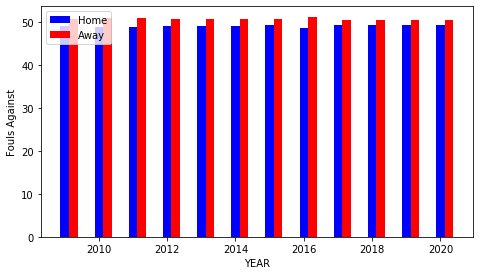

In [46]:
plot_referee_stat_by_year(ref_df, 'FAH%', 'FAR%')

In [47]:
perform_z_test(ref_df['FAH%'], ref_df['FAR%'])

Z statistic :  -16.199077354022496
p value :  5.1189334084260145e-59
Reject null hypothesis, i.e., there is significant difference between the 2 samples.


#### Conclusion:
    
We can see that there is significant difference between fouls awarded to home and away players. 
On average, a referee is more likely to give away fouls to the home team than the away team. 

* [Go back to table of contents](#main)